In [1]:
import csv
import pandas as pd
from scipy.stats import pearsonr
import os.path
import matplotlib.pyplot as plt
from statsmodels.genmod.families import Poisson, NegativeBinomial
import statsmodels.api as sm
import numpy as np
encoding='iso-8859-1'
figure_folder = "figures/"

In [3]:
all_projects = ['eclipse.platform', 'guava', 'guice', 'hadoop', 'spark', 'flow' ]
datas = {}
for project in all_projects:
    print( "project: ", project)
    df = pd.read_csv(project+"/data.csv")
    datas[project] = df


project:  eclipse.platform
project:  guava
project:  guice
project:  hadoop
project:  spark
project:  flow


In [152]:
def generate_histograms(col):
    project_correlations = {}
    fig, axes = plt.subplots(nrows=2, ncols=3, dpi=1200)
    i = 0
    for project in all_projects:
        print("\t"+project)
        df = datas[project]
        df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
        comments = df[col]
        mx = comments.max()+1 if comments.max()+1 >= len(pd.unique(comments)) else len(pd.unique(comments))
        print( comments.max() )
        if 'loc' in col:
            mx = 100
        comments.plot.hist(bins=mx,ax=axes[i//3,i%3])
        axes[i//3,i%3].set_title(project)
        i += 1
    fig.tight_layout()
    fig.savefig(figure_folder+"Distribution_"+col.replace('/','=')+".png")

In [159]:
def intersection(a,b):
    b = b.columns
    return __intersection(a,b)

def __intersection(a,b):
    return list(set(a) & set(b))

for project in all_projects:
    print(project, datas[project]['Number of commentsComment/loc'].replace([np.inf, -np.inf], np.nan).dropna(axis=0).mean() )

eclipse.platform 0.2526831337472396
guava 0.16114721309077004
guice 0.30883543110634937
hadoop 0.183967526660743
spark 0.2503924655806279
flow 0.2383917714273271


Number of commentsComment/loc
	eclipse.platform
2.0277777777777777
	guava
2.0
	guice
2.0
	hadoop
2.0
	spark
2.0
	flow
0.9838709677419355
Number of line comments/loc
	eclipse.platform
1.3134328358208955
	guava
0.463855421686747
	guice
0.3219178082191781
	hadoop
1.3
	spark
1.1893939393939394
	flow
0.5789473684210527
Number of Block comments/loc
	eclipse.platform
0.5454545454545454
	guava
1.0
	guice
1.0
	hadoop
1.0
	spark
1.0
	flow
0.38461538461538464
Number of Javadoc comments/loc
	eclipse.platform
2.0
	guava
1.0
	guice
1.0
	hadoop
2.0
	spark
1.0
	flow
0.9436619718309859
Number of comments in methode/loc
	eclipse.platform
0.766798418972332
	guava
0.6037735849056604
	guice
0.5
	hadoop
0.7
	spark
1.0
	flow
0.7678571428571429
Number of method comments/loc
	eclipse.platform
0.9685863874345549
	guava
0.8877005347593583
	guice
0.7857142857142857
	hadoop
0.90625
	spark
0.6153846153846154
	flow
0.9295774647887324
Number of class comments/loc
	eclipse.platform
1.0833333333333333
	guava
1.0
	guice

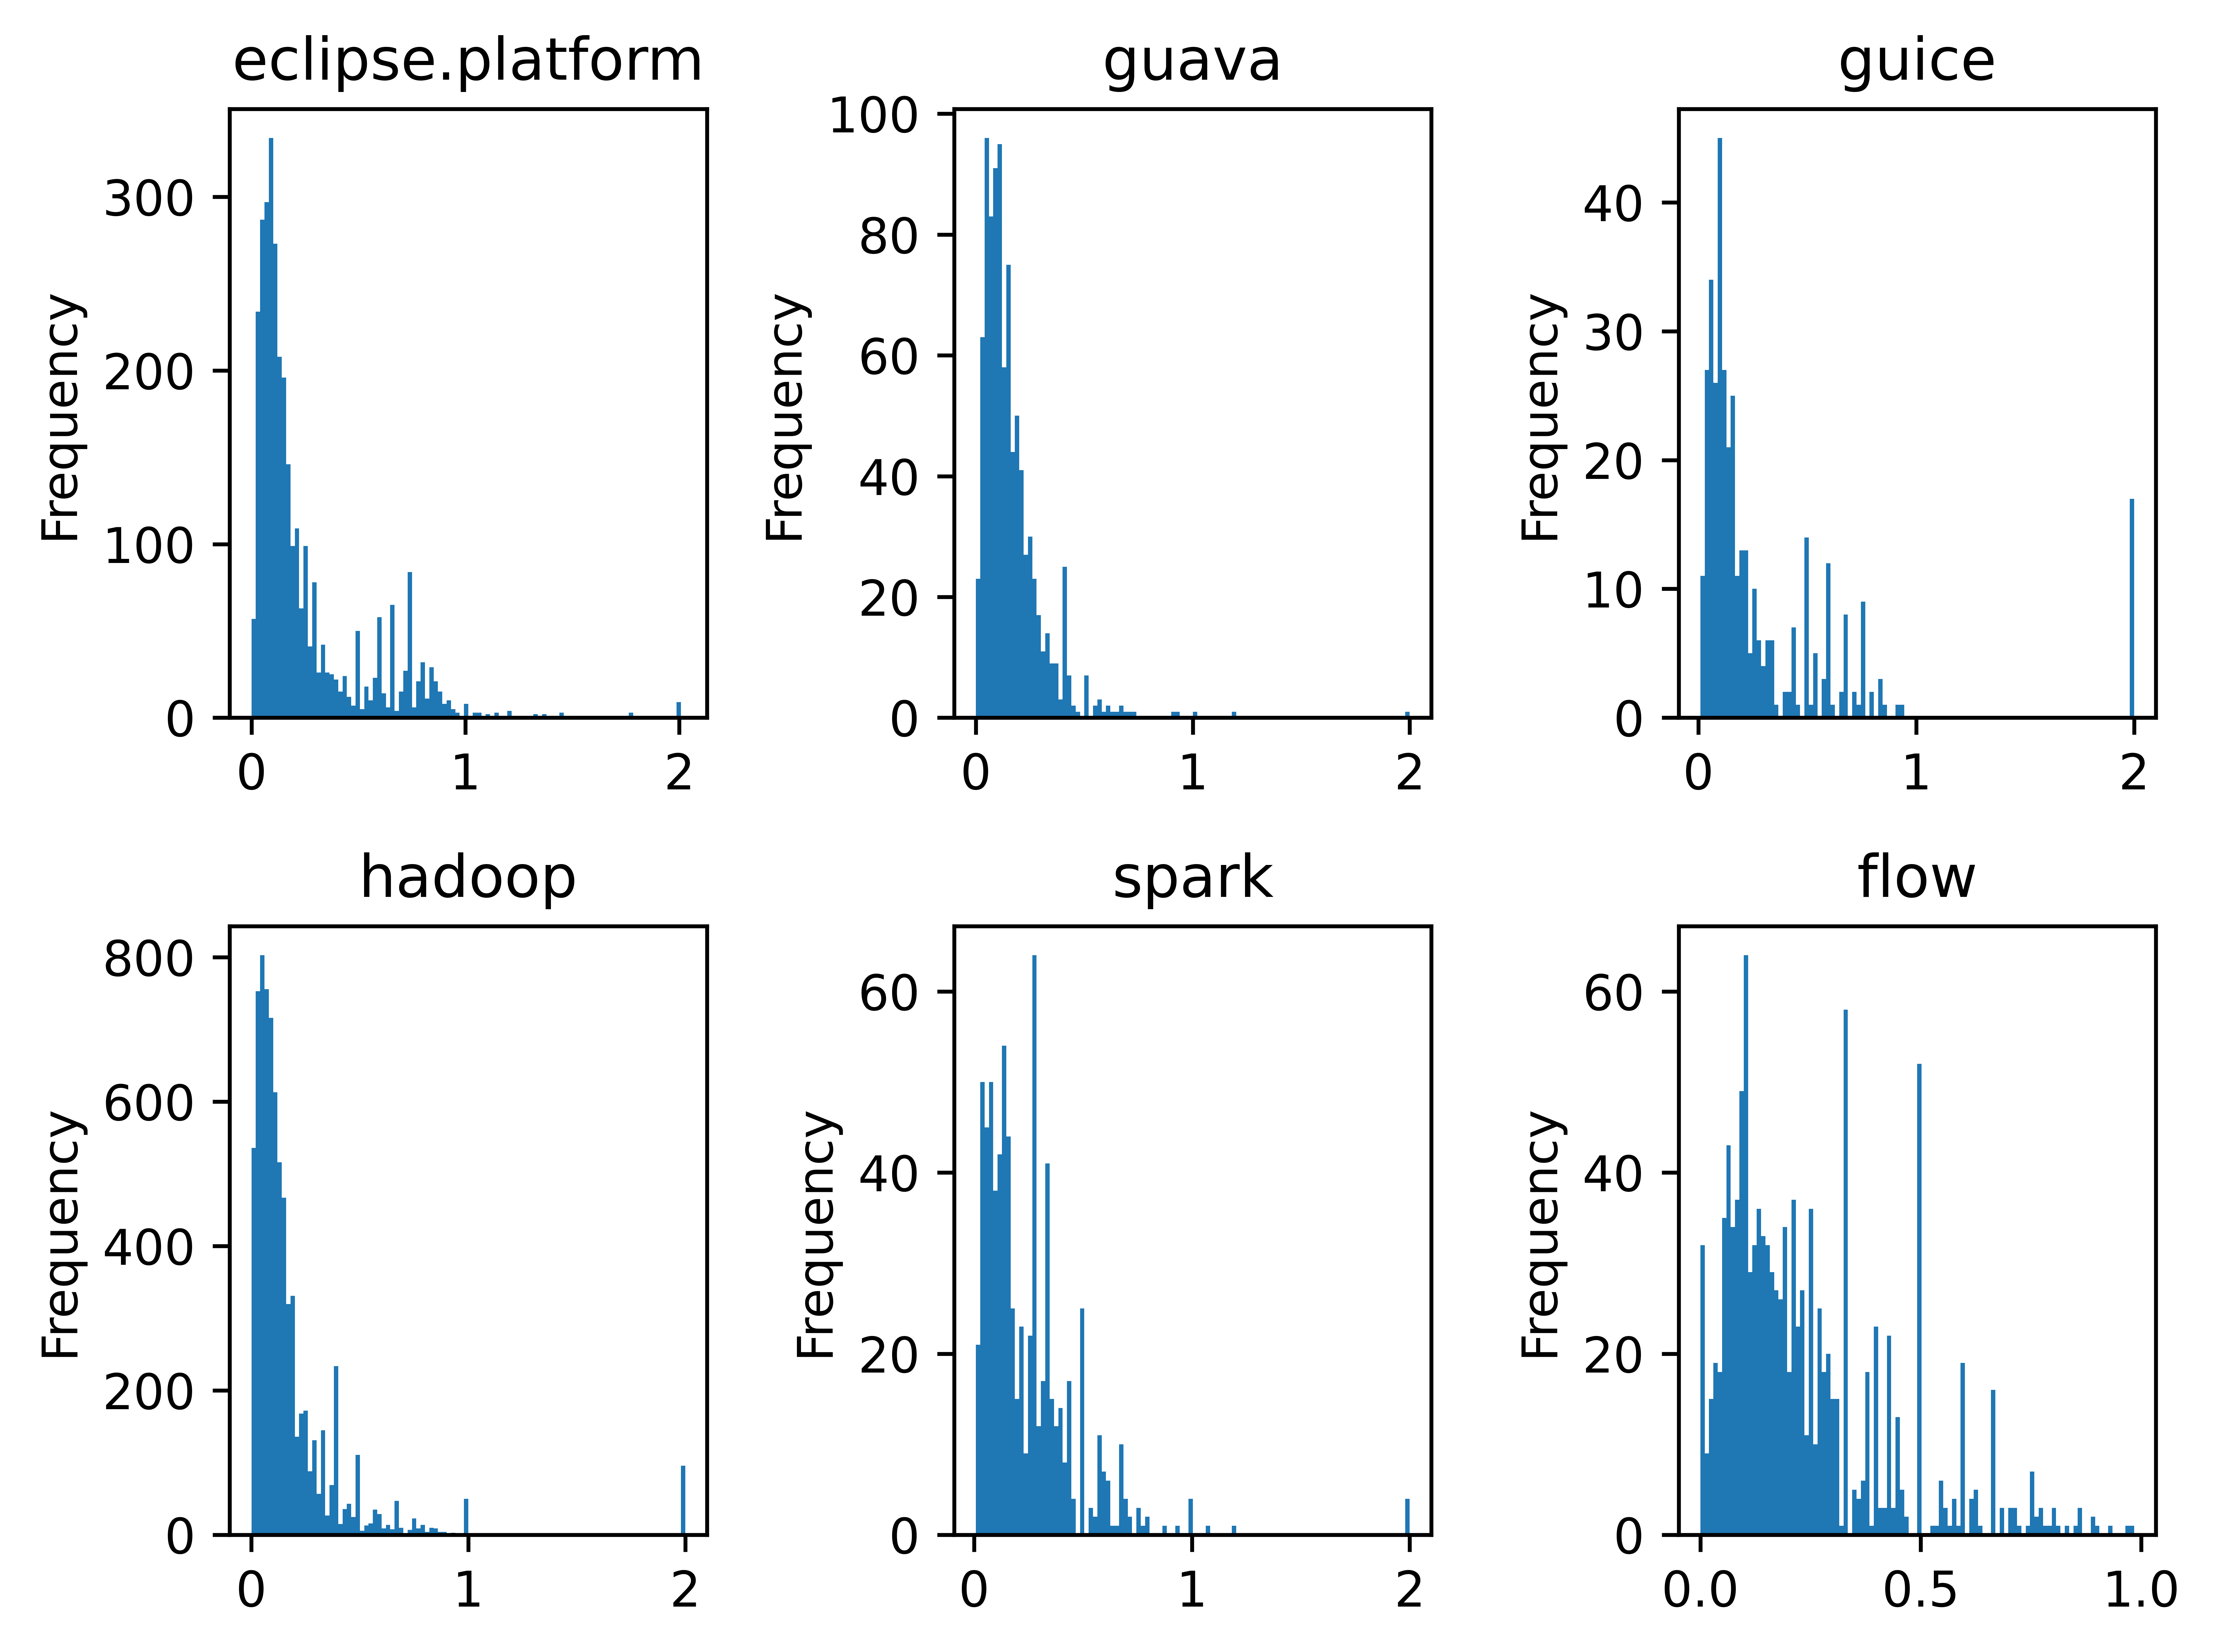

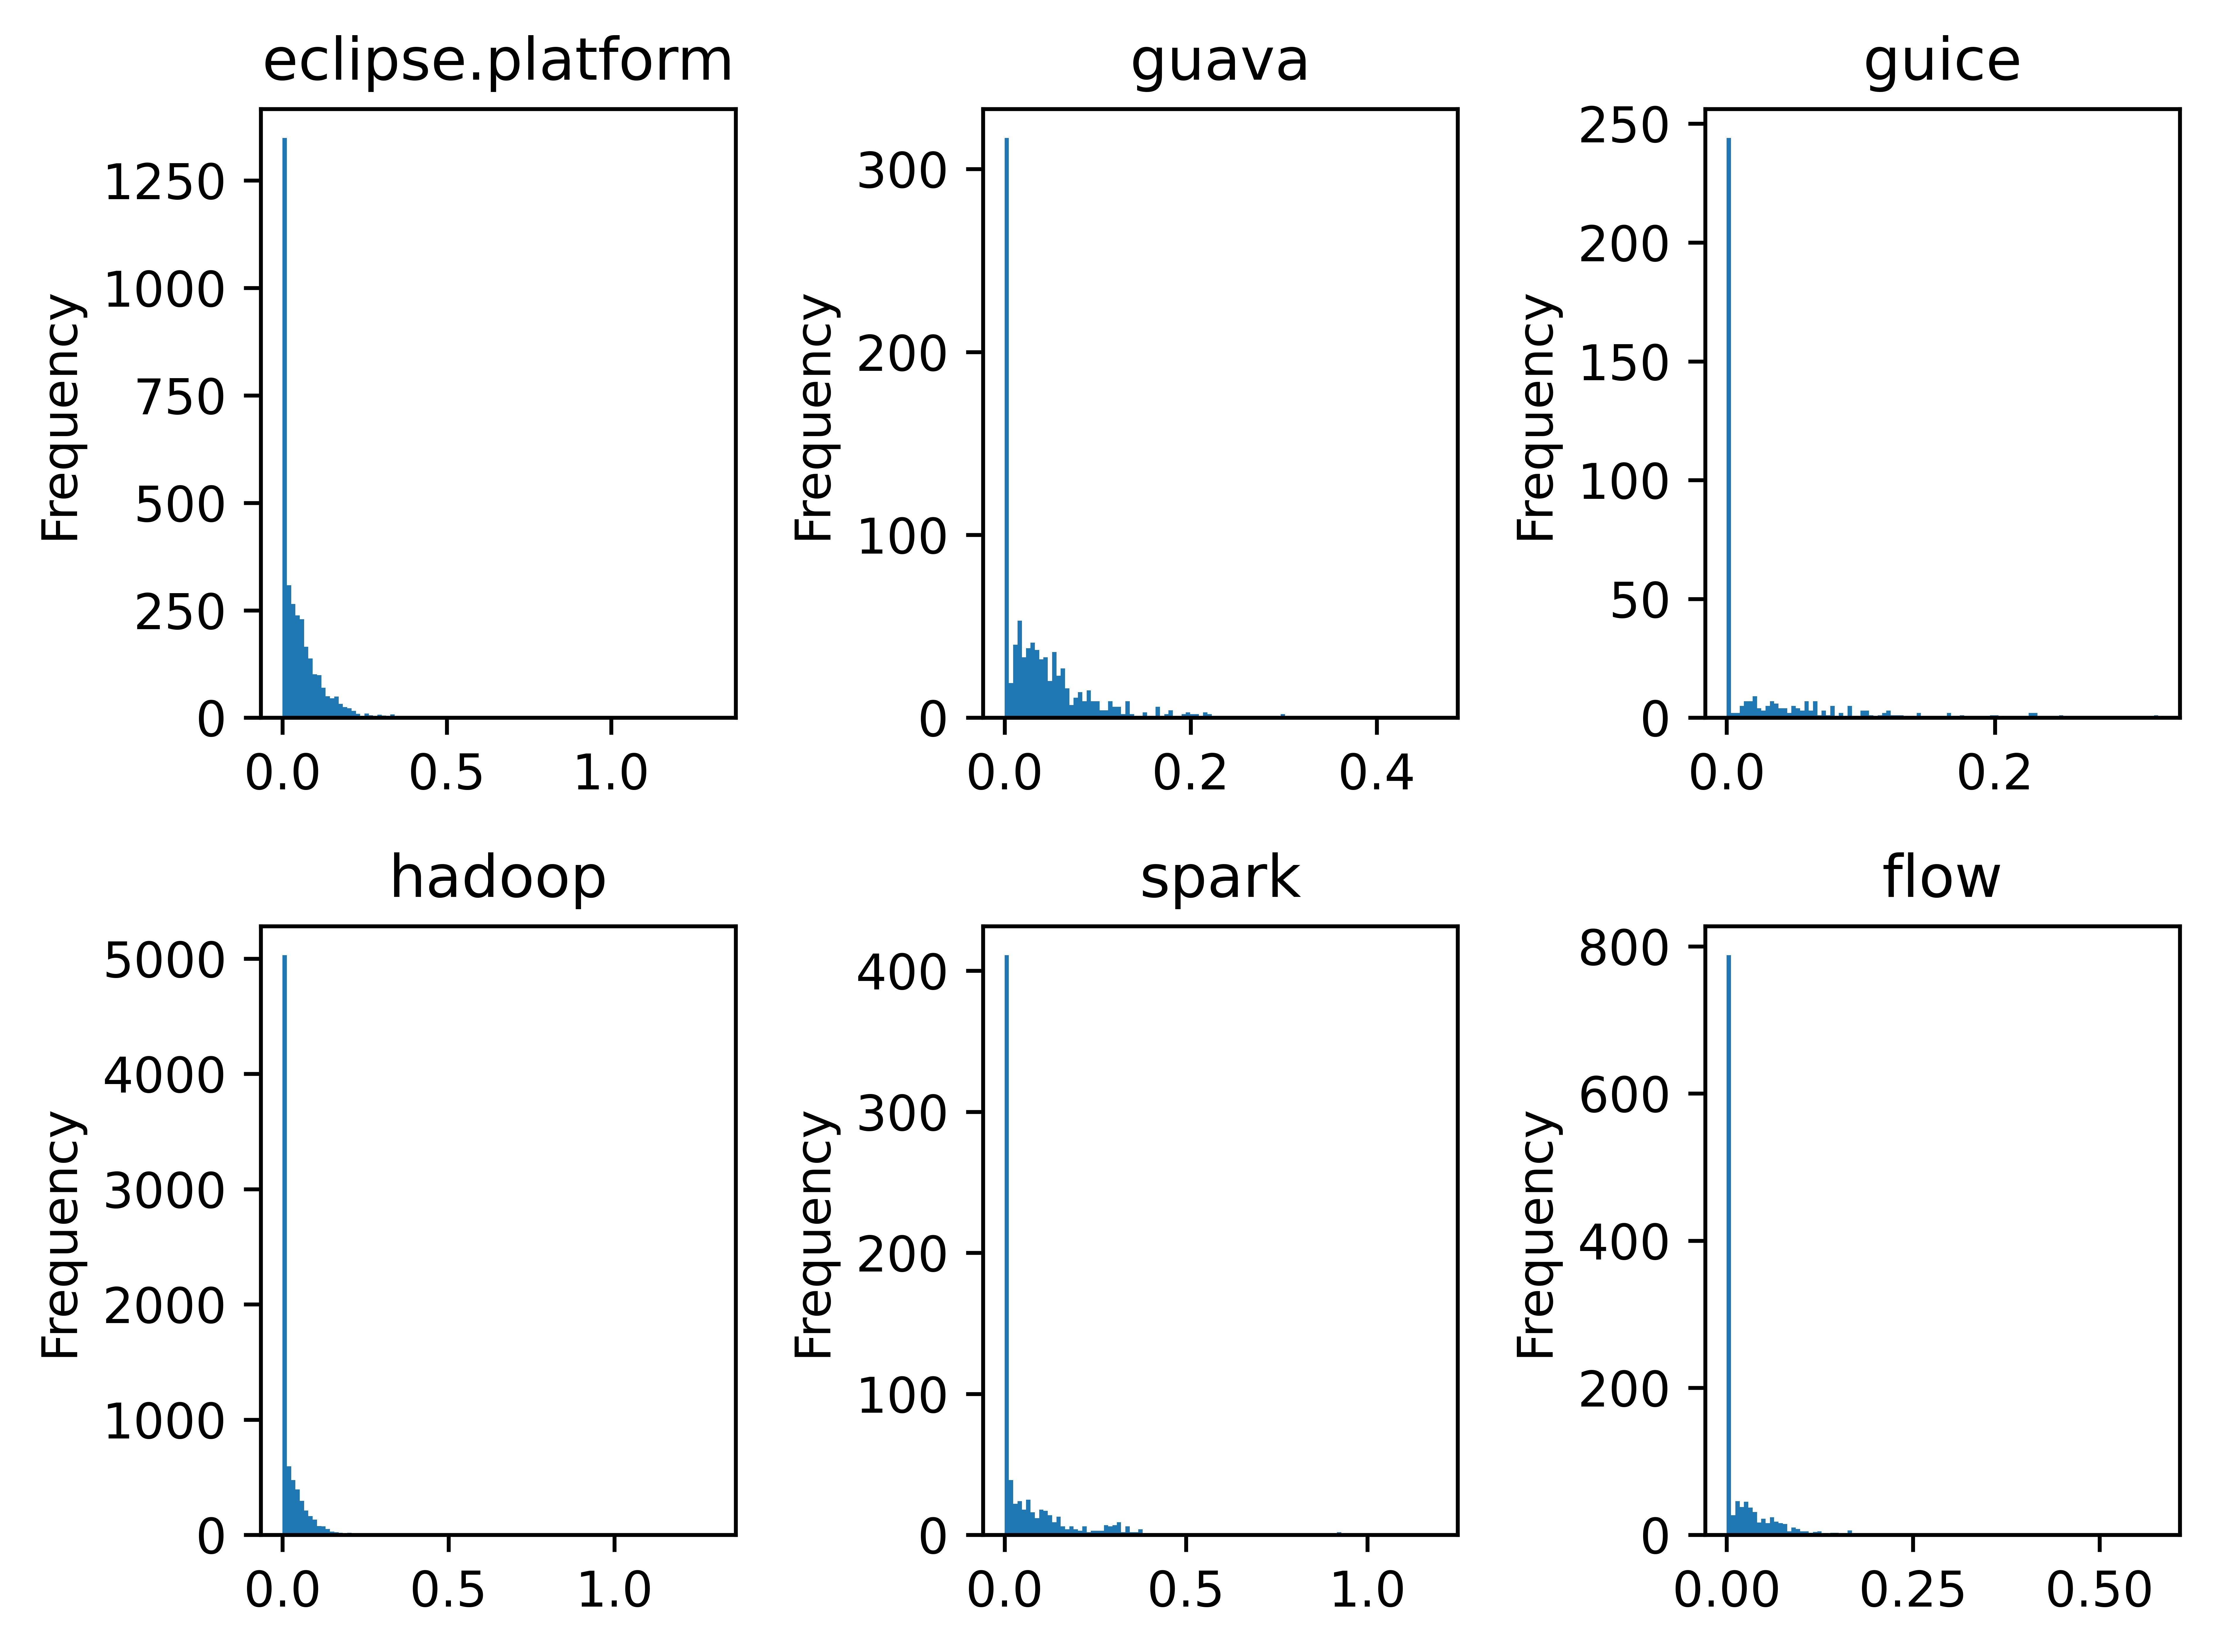

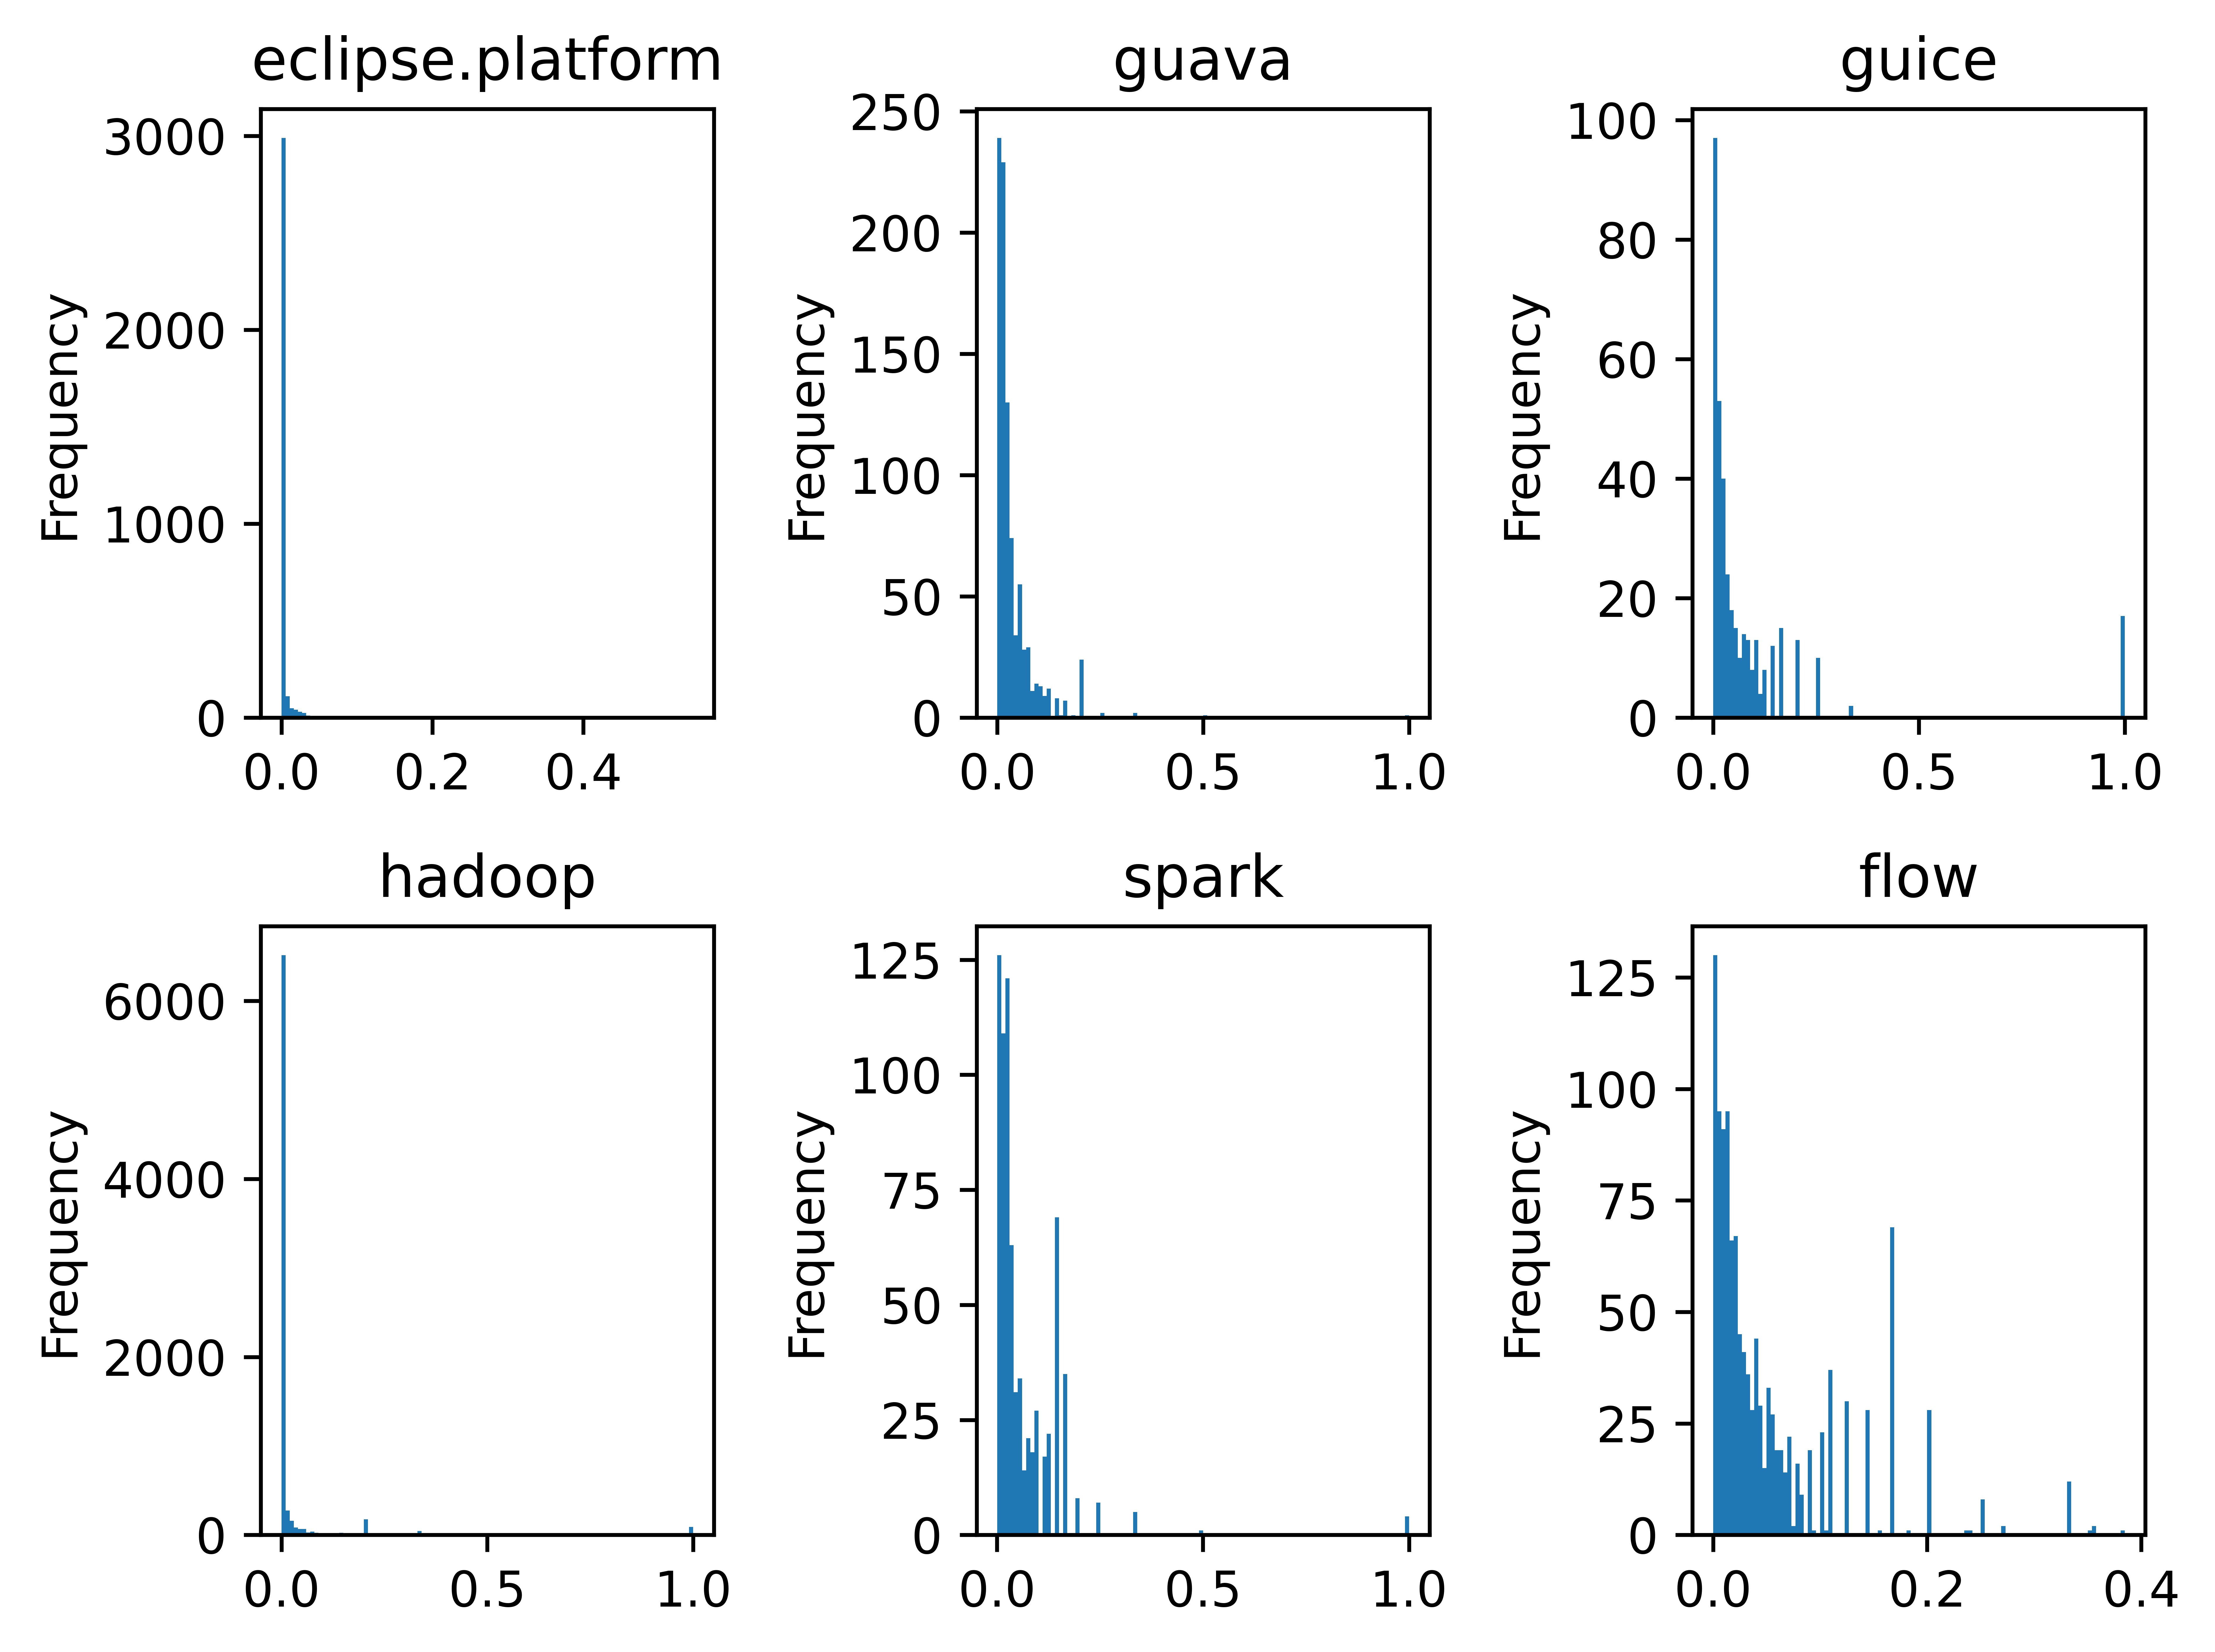

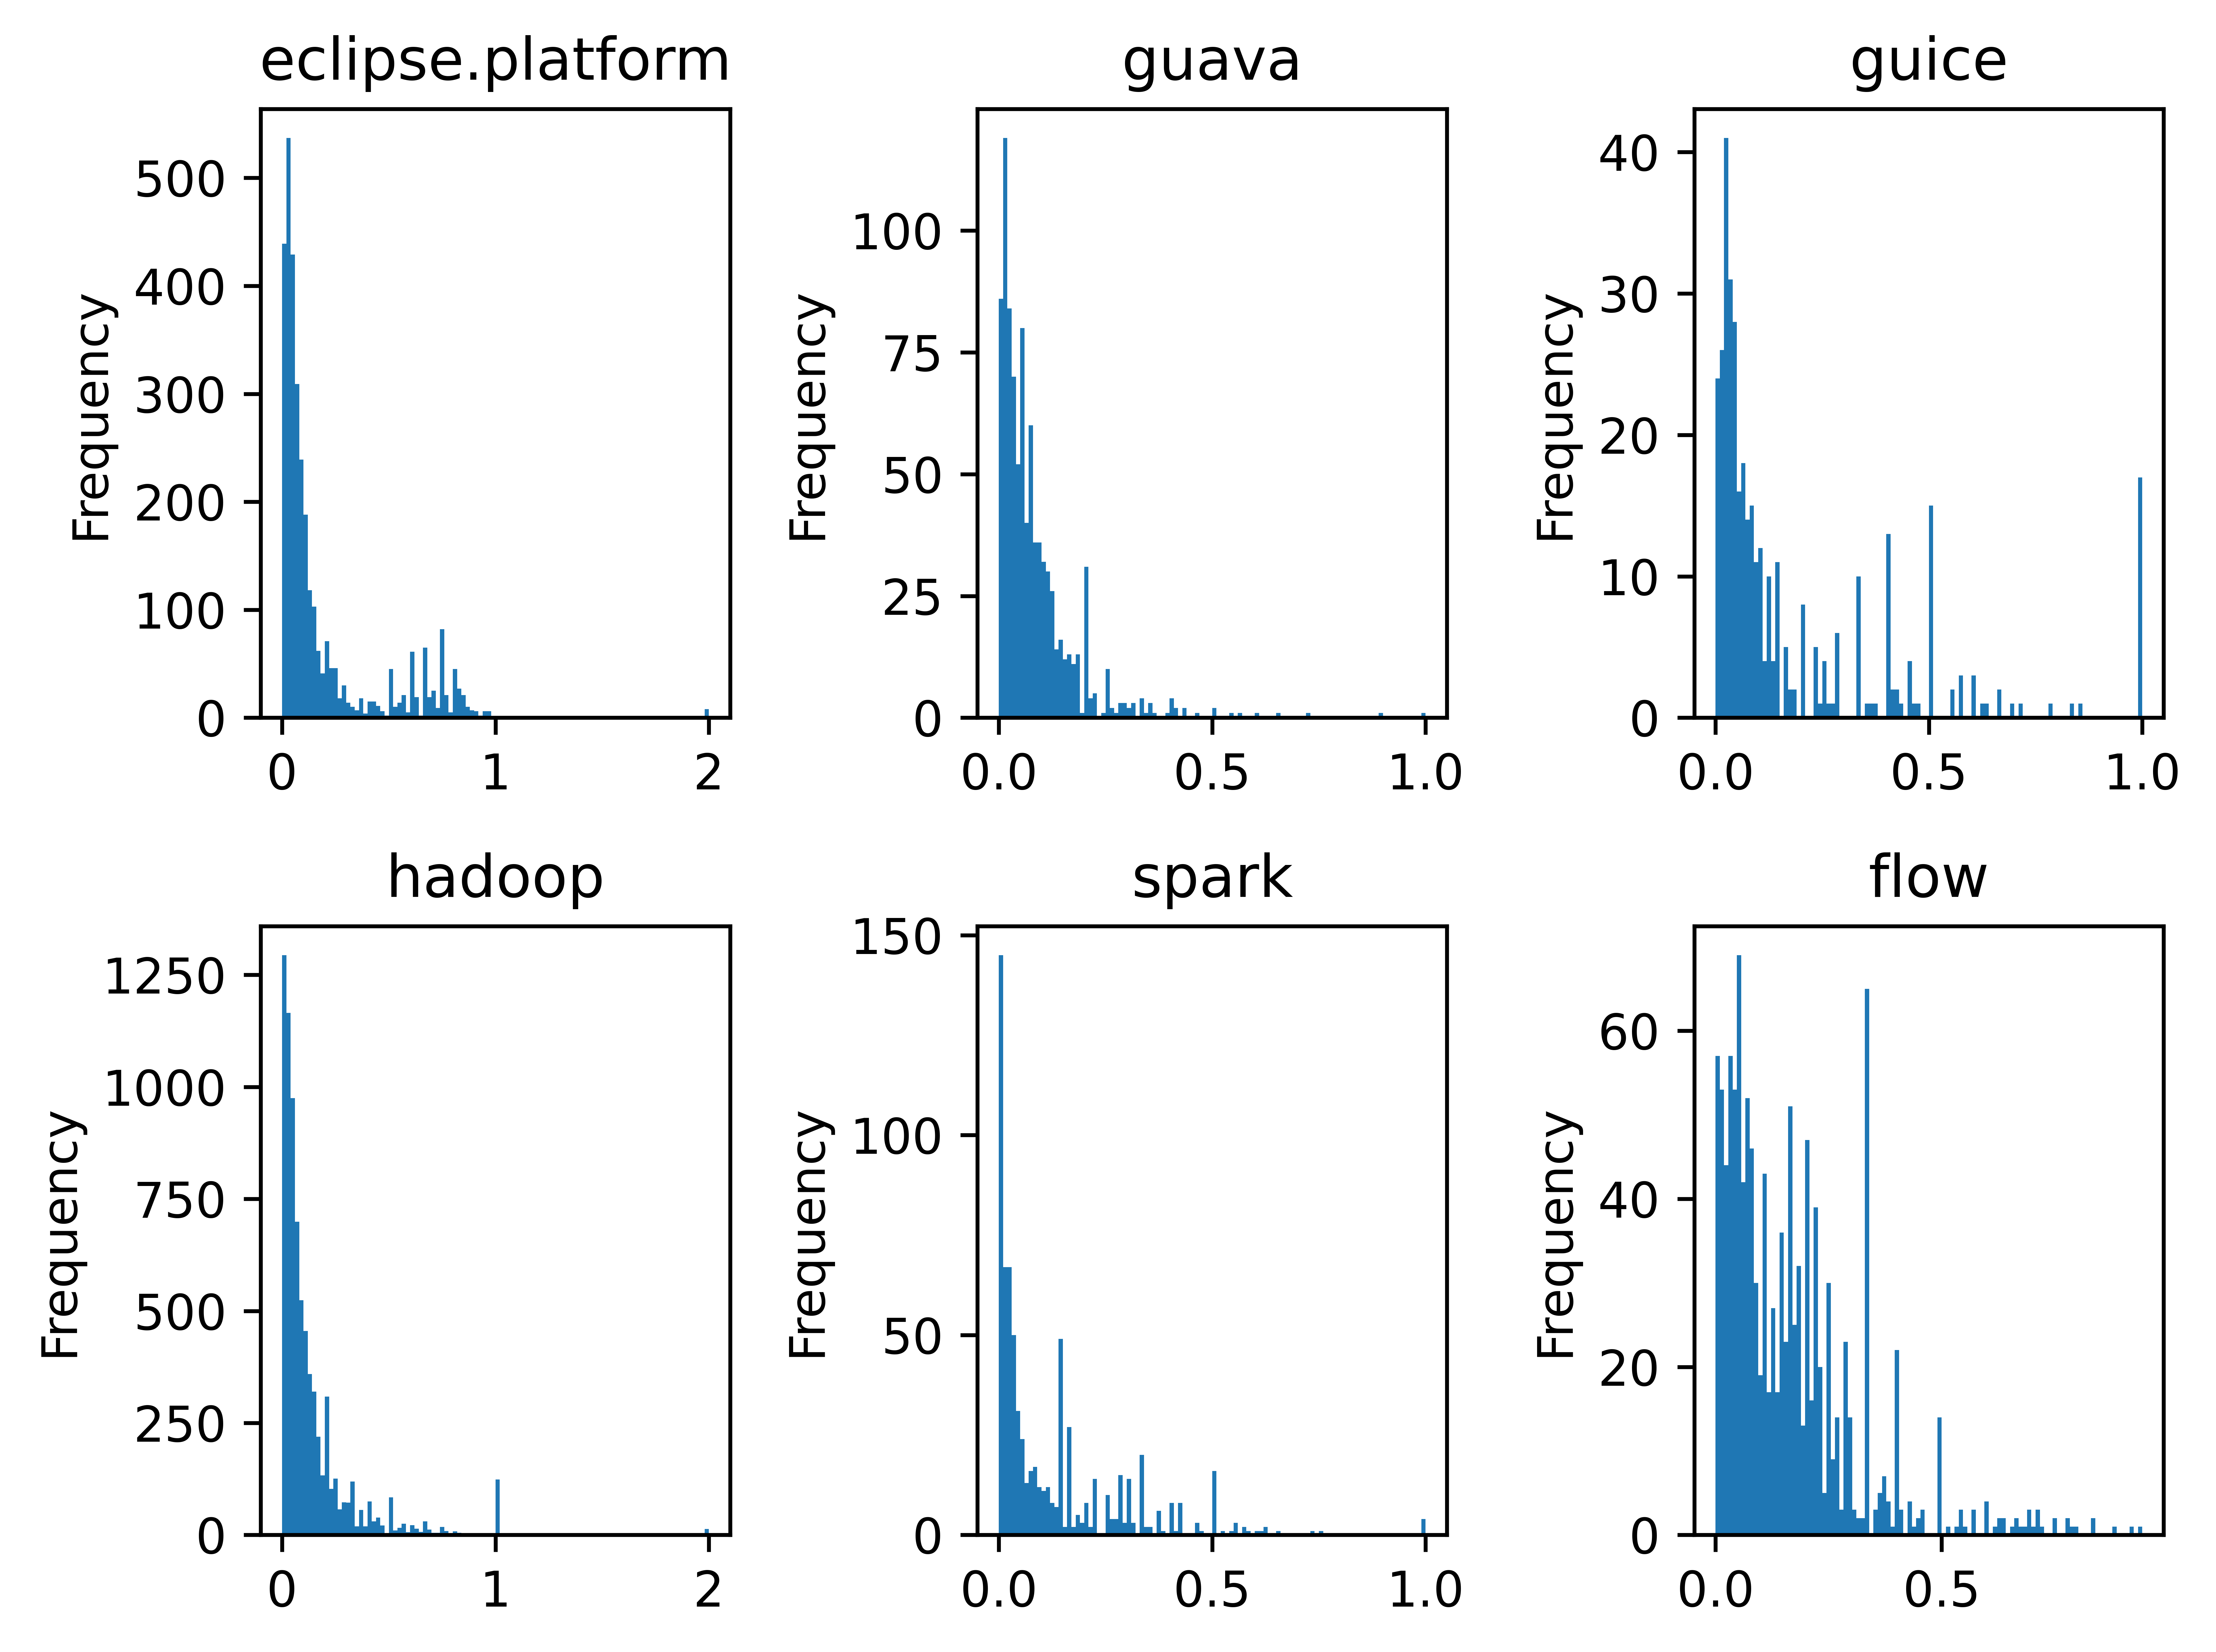

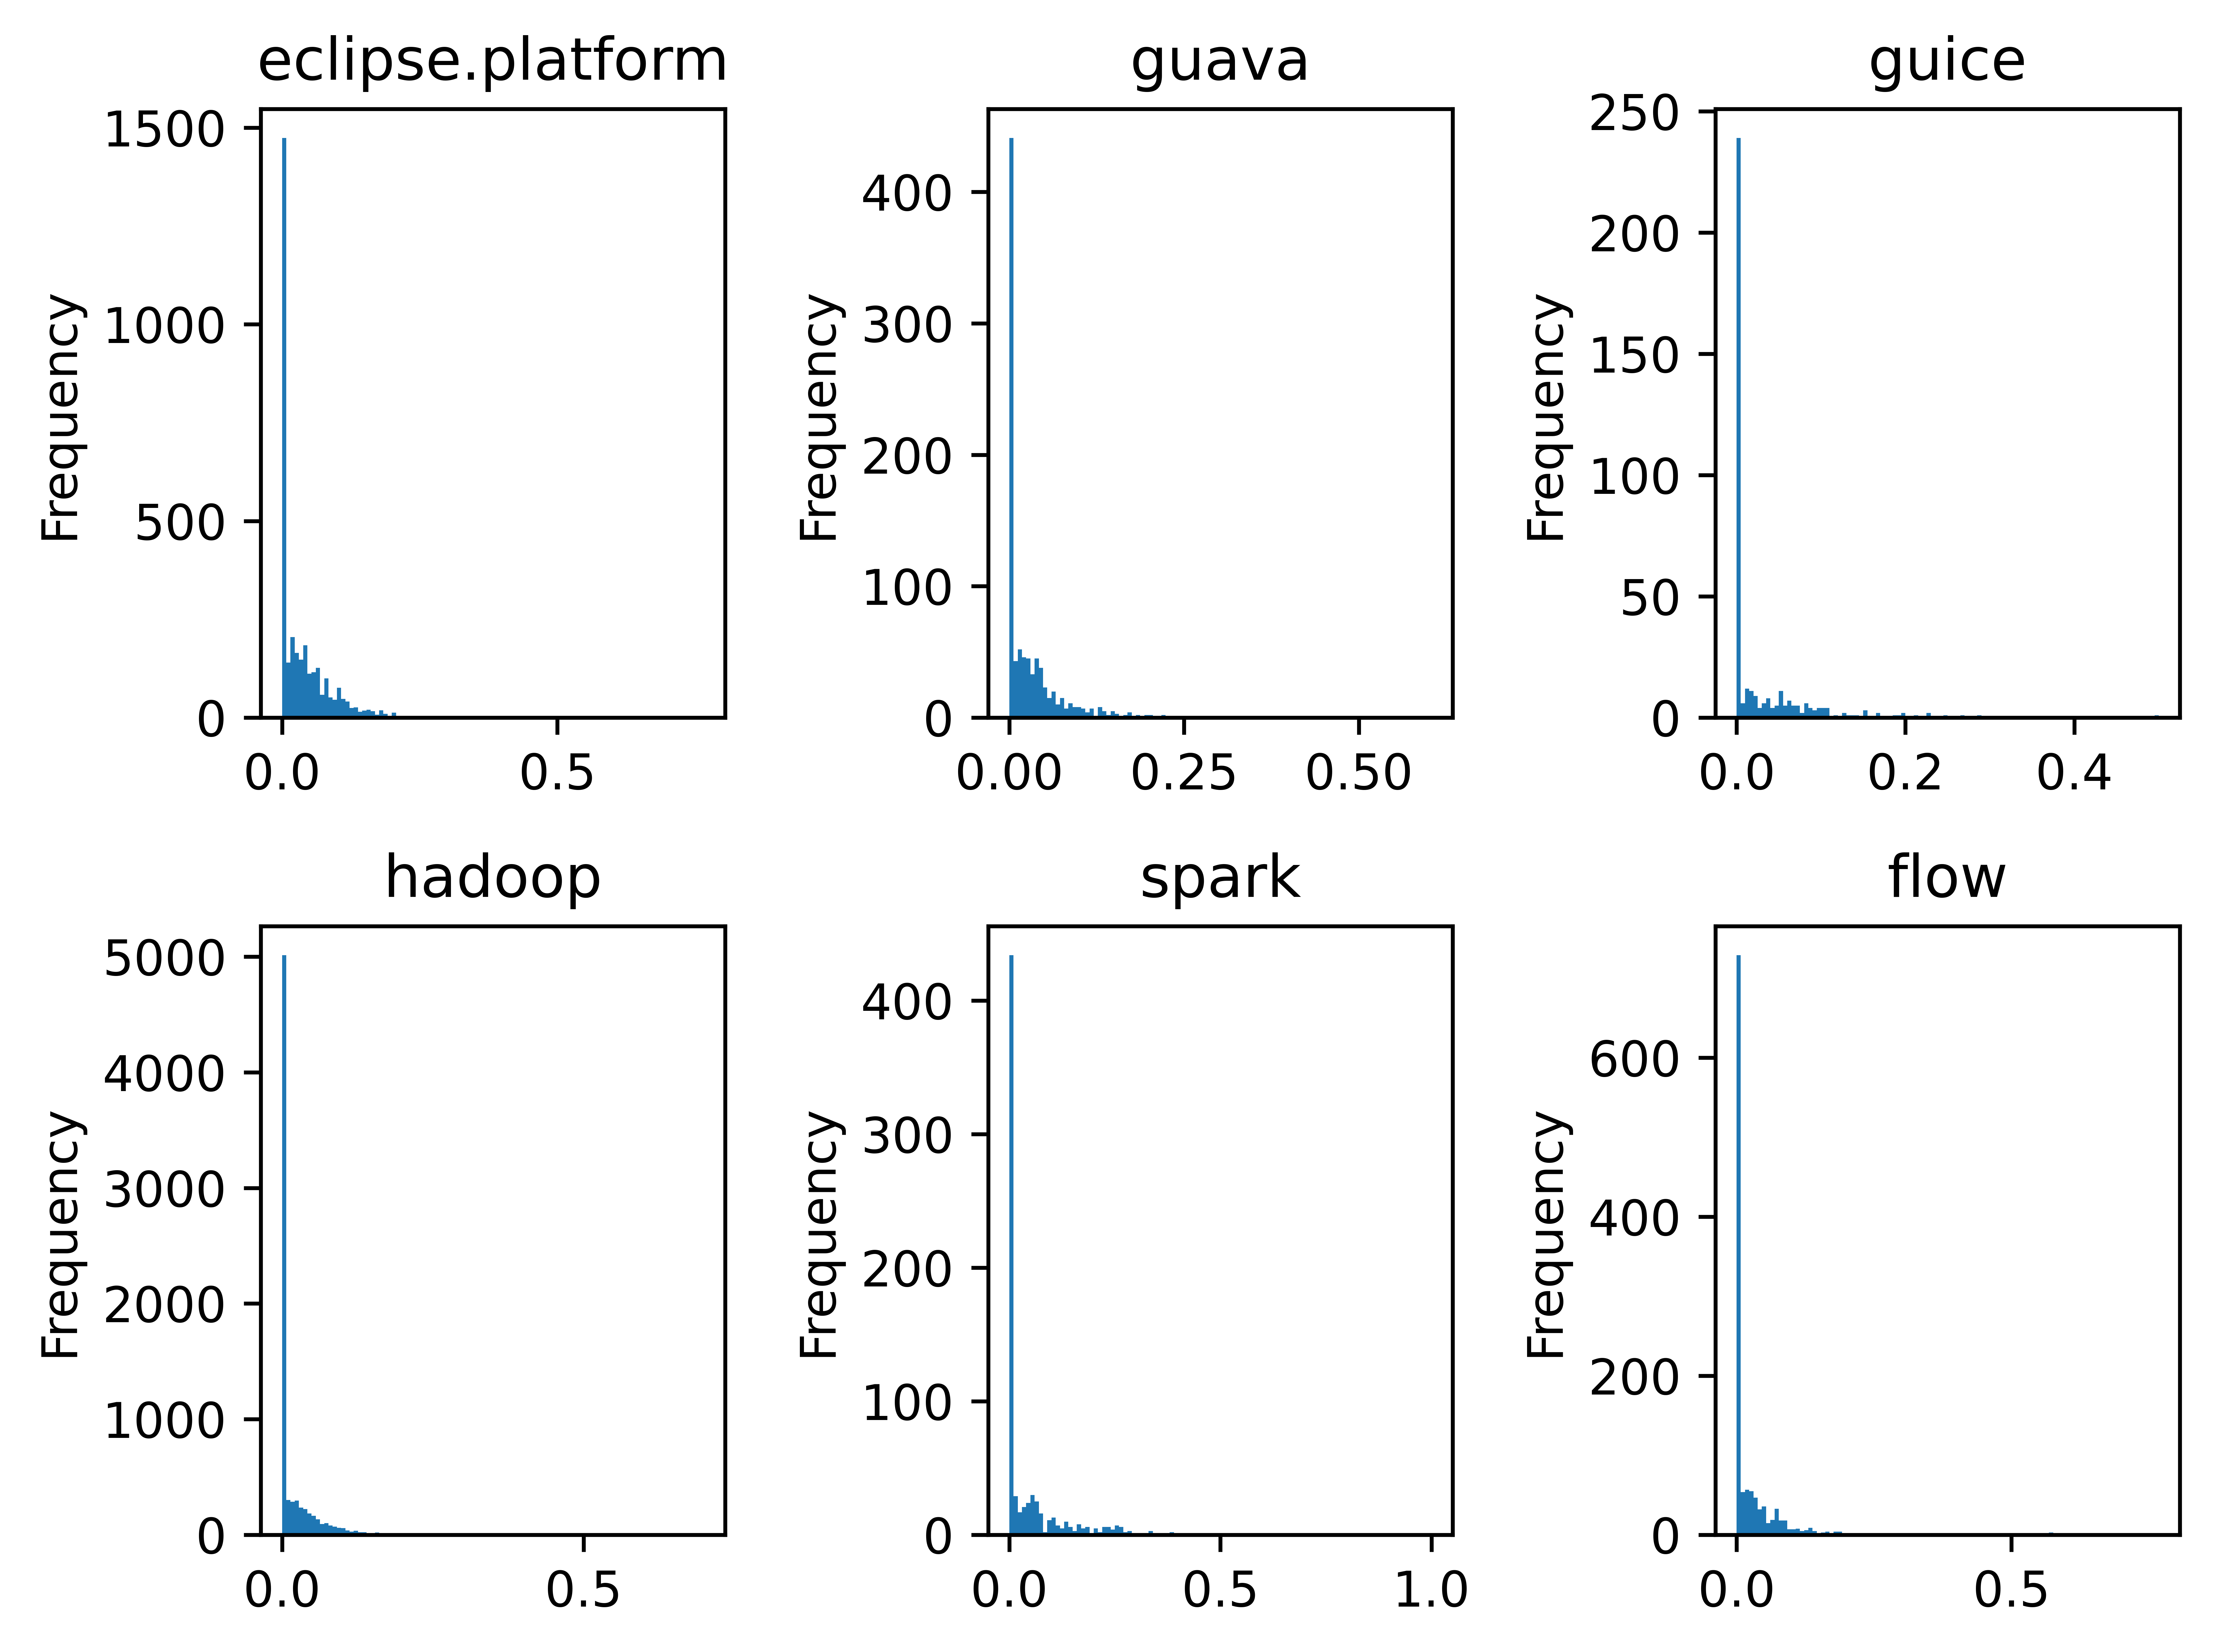

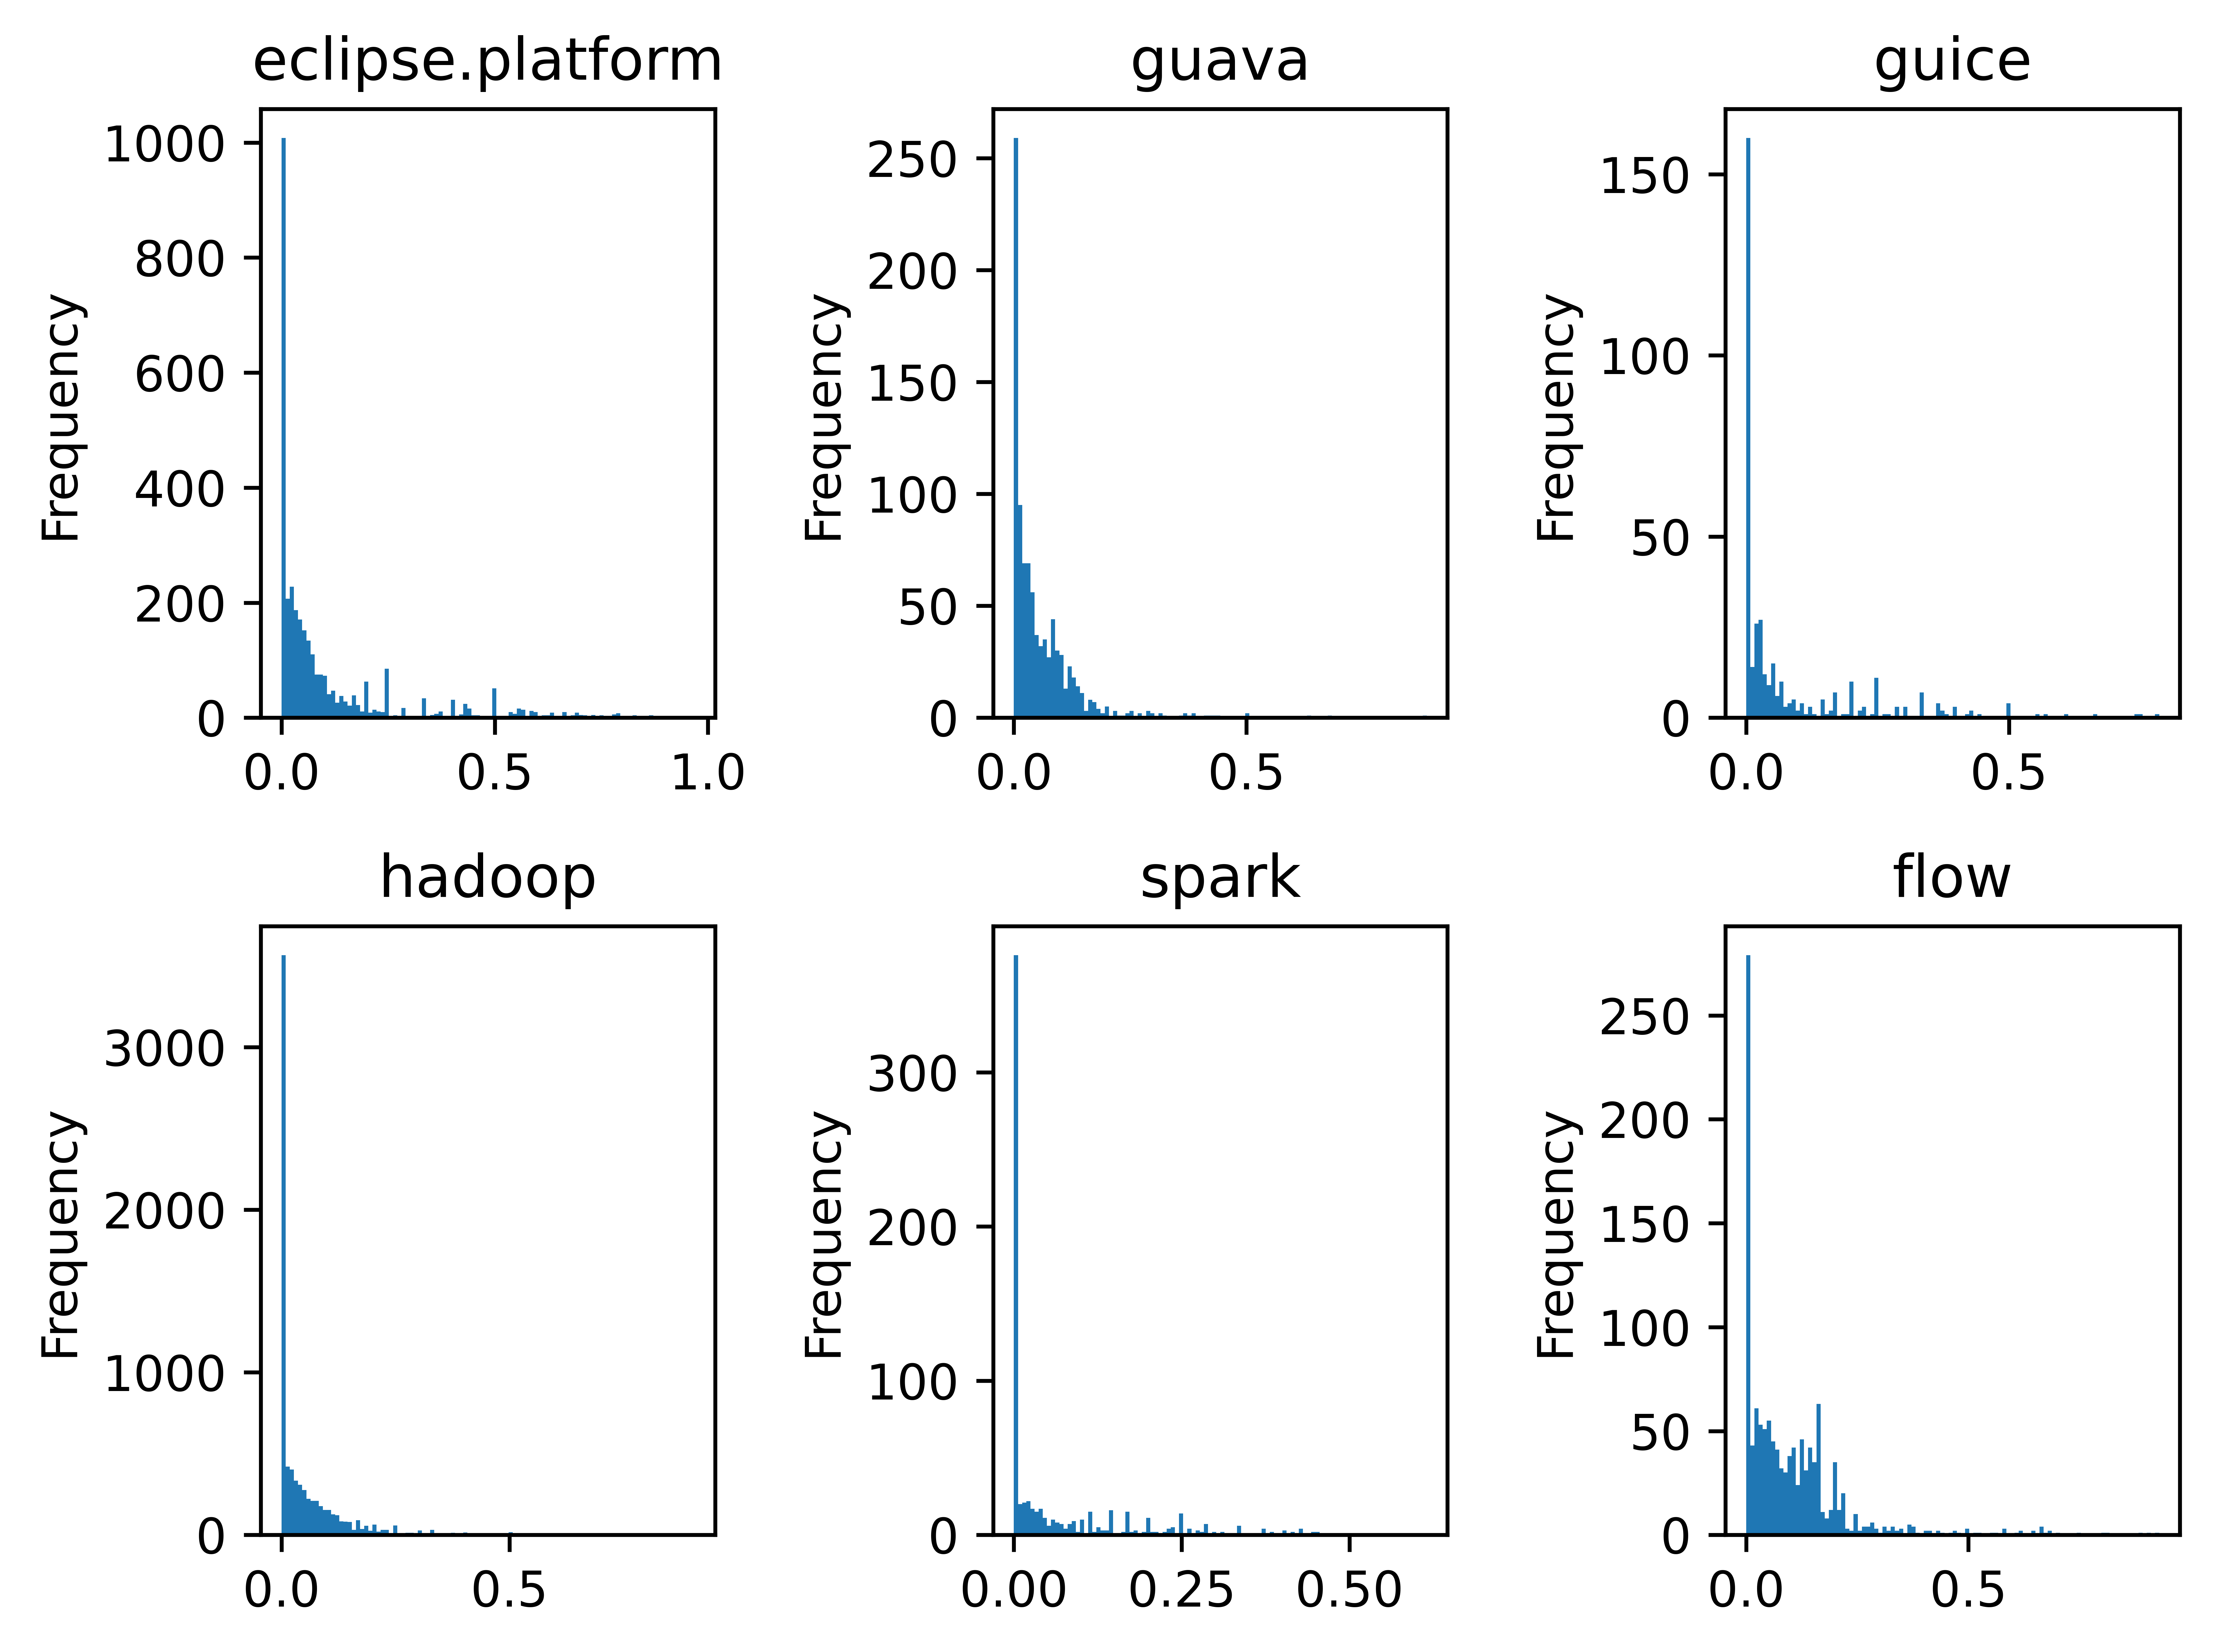

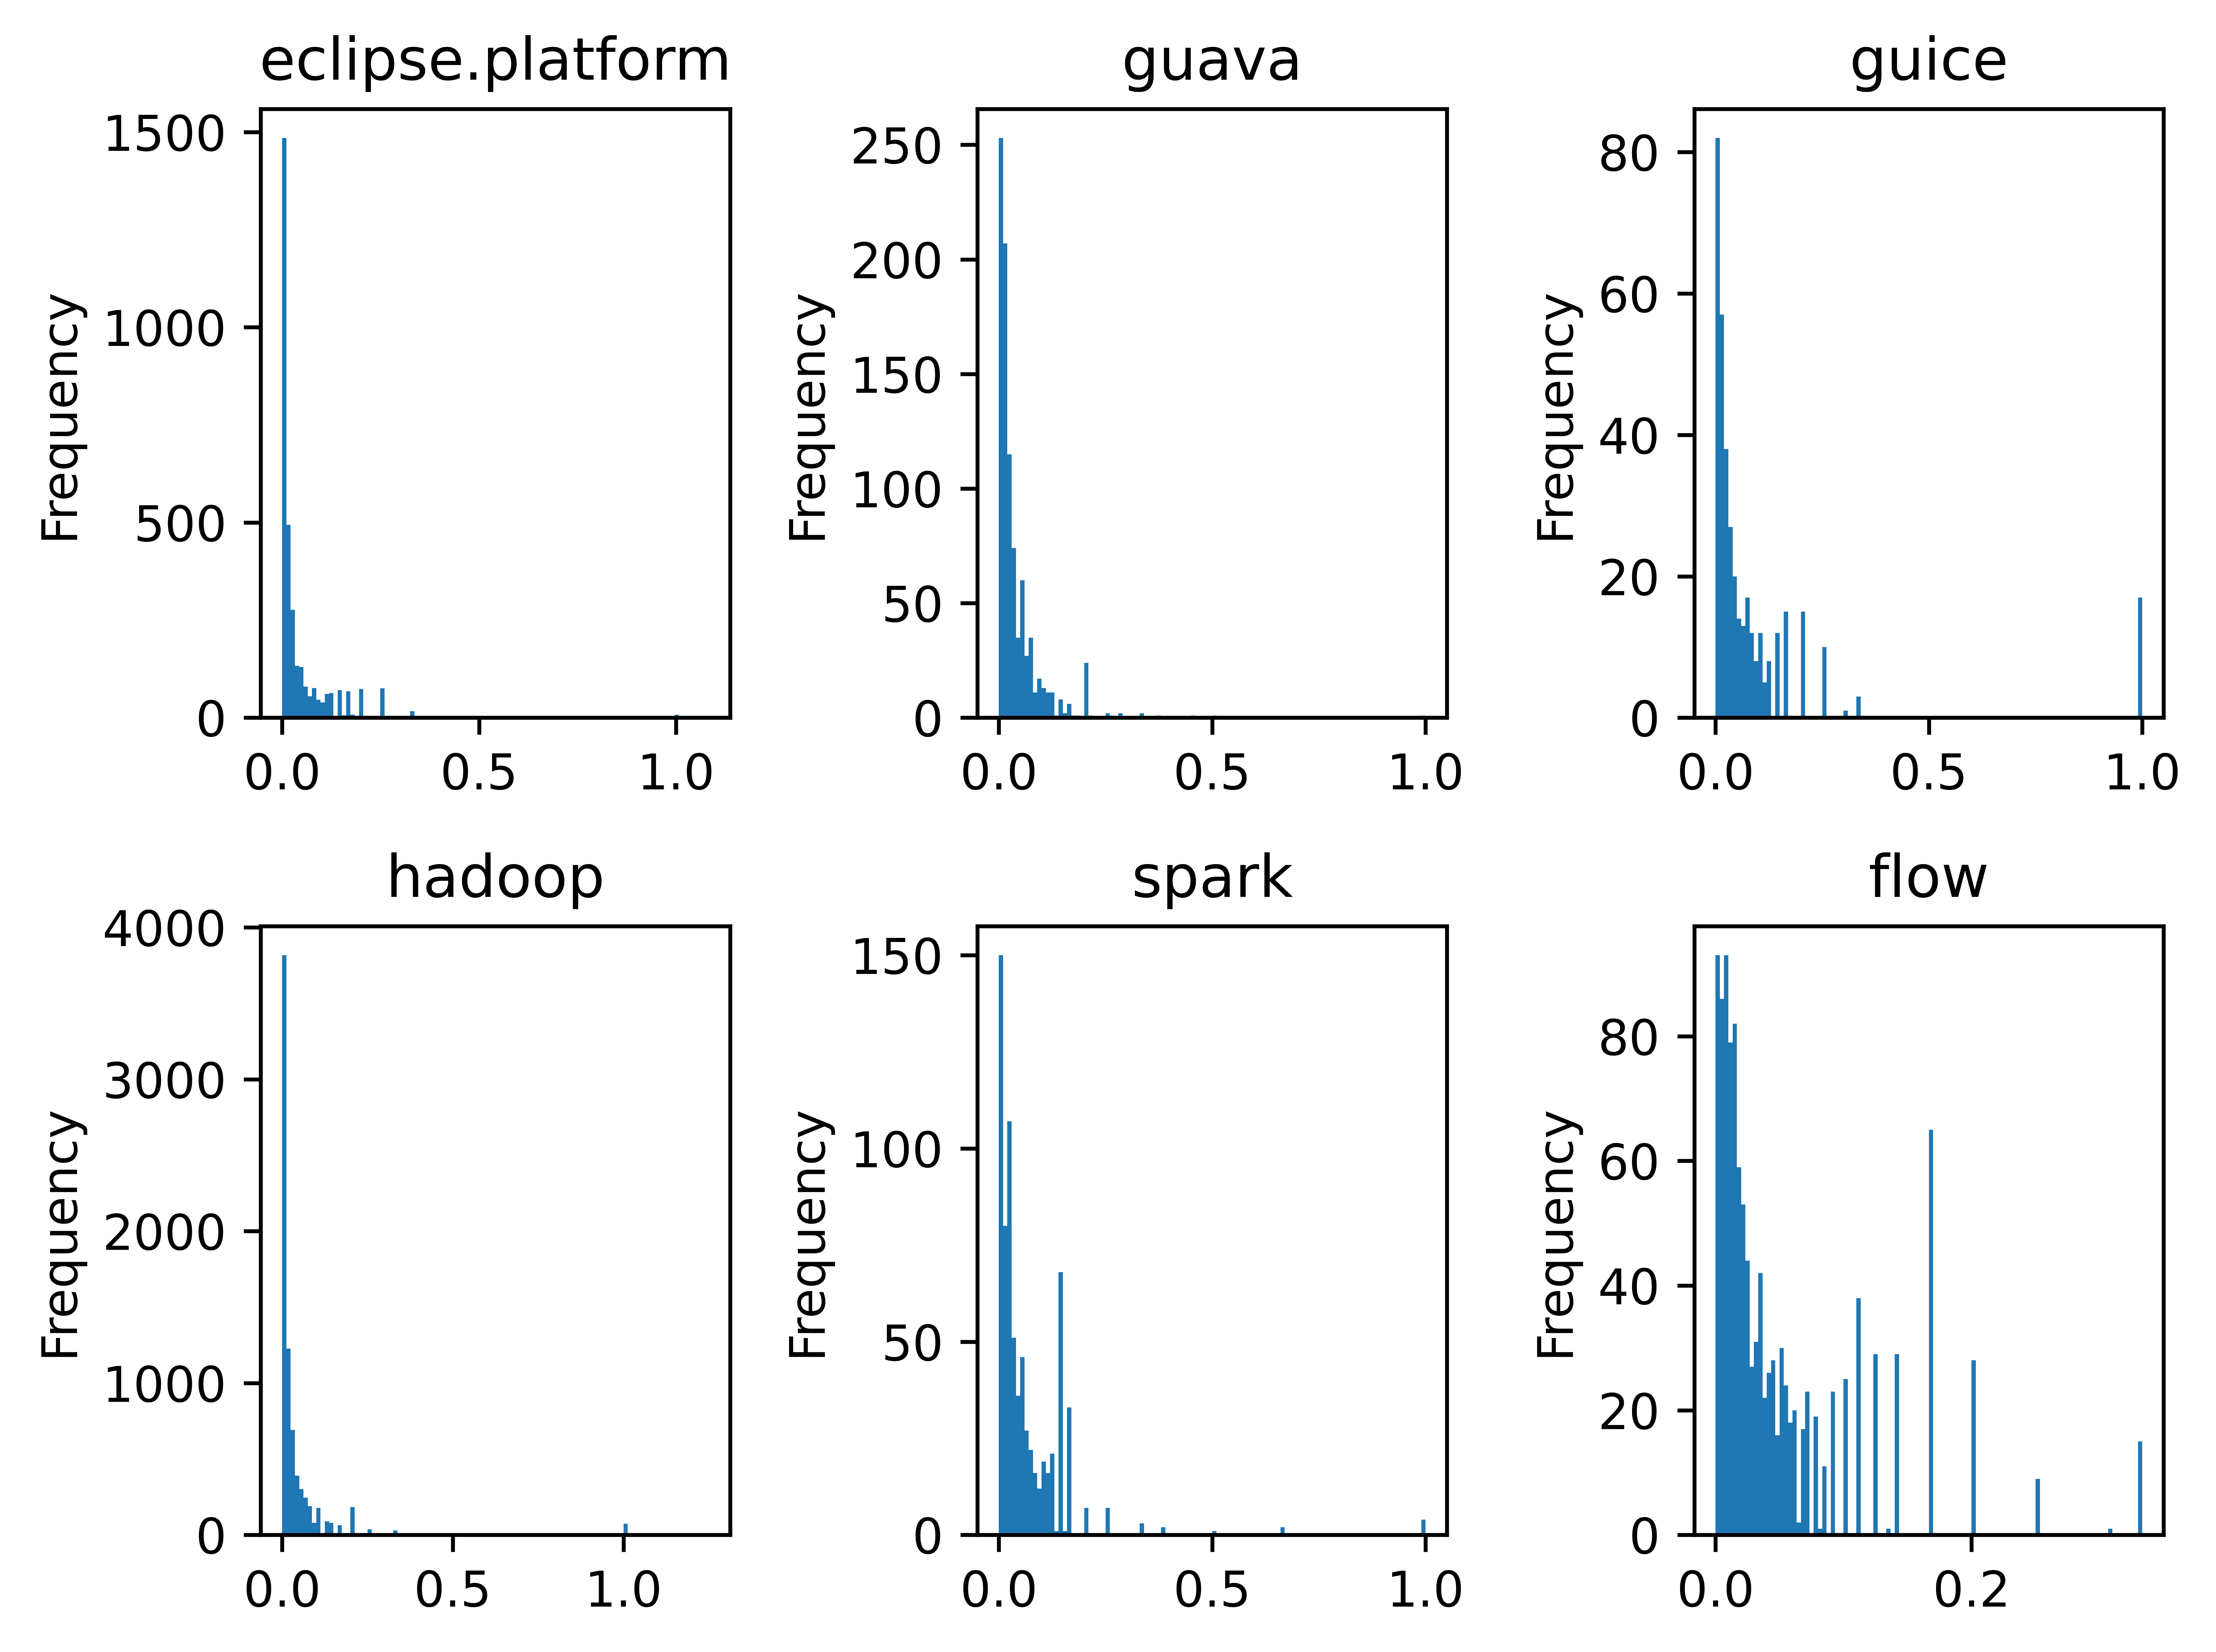

In [153]:


for comment_type in comments_types:
    print(comment_type+'/loc')
    generate_histograms(comment_type+'/loc')

In [10]:
l = []
for comment_type in comments_types:
    name = comment_type+"/loc"
    for project in all_projects:
        df = datas[project]
        if not name in df:
            df[name] = df[comment_type]/df['loc']
    l.append(name)

comments_types = comments_types+tuple(l)

In [11]:
rules_pmd = []
rules_sonar = []
rules_sum = ['all_sonar', 'all_pmd', 'all_rulebreaks']

for project in all_projects:
    df = datas[project]
    for column in df:
        if column == "pmd_-":
            df.drop(column, axis=1)
            continue
        if 'pmd' in column and not column in rules_pmd:
            rules_pmd.append(column)
        if 'sonar' in column and not column in rules_sonar:
           rules_sonar.append(column)
            
for project in all_projects:
    df = datas[project]
    for column in rules_pmd + rules_sonar:
        if not column in df:
            #df[column] = 0
            #print("found one")
            pass

    if not 'all_sonar' in df:
        df['all_sonar'] = df[intersection(rules_sonar,df)].sum(axis=1)
    if not 'all_pmd' in df:
        df['all_pmd'] = df[intersection(rules_pmd,df)].sum(axis=1)
    if not 'all_rulebreaks' in df:
        df['all_rulebreaks'] = df['all_sonar'] + df['all_pmd']
    datas[project] = df.copy()

#glm = statsmodels.formula.api.gee
#sm.GLM(df['Number of commentsComment'], df[rules] , family = Poisson()).fit().summary()

https://stats.oarc.ucla.edu/stata/output/poisson-regression/

In [12]:
#glm = statsmodels.formula.api.gee

def generate_recursion(column, rules):
    cor = {}
    for project in all_projects:
        df = datas[project]
        rules = intersection(rules, df)
        result_df = pd.DataFrame([],  columns =  ["cor", "p", 'ratio'])
        for rule in rules:
            cur = None
            al = None
            for alpha in np.arange(1,10,0.1):
                alpha = alpha**2
                try:
                    res = sm.GLM(df[column], df[rule] , family = NegativeBinomial(alpha=alpha)).fit() #alpha=ratio
                    if cur == None:
                        cur = res.llf
                        al = alpha
                    elif cur < res.llf:
                        cur = res.llf   
                        al = alpha 
                except Exception:
                    pass
            result_df.loc[rule] = [res.params[rule], res.pvalues[rule], al]
        cor[project] = result_df.copy()
    return cor



In [67]:
def plot_recursion(comment_metric,rules,rule_name):
    cor = generate_recursion('Number of commentsComment', rules)
    fig, axes = plt.subplots(nrows=2, ncols=3, dpi=1200)
    i = 0
    recursions = {}
    
    for project in all_projects:
        ax = axes[i//3,i%3]
        res = cor[project]
        df =res
        #df = pd.concat( res[rules]['cor'],res[rules]['p'], axis=1)
        df.plot.scatter(x='cor', y='p', c='DarkBlue', marker='x', ax=ax)

        x = [df['cor'].min(),df['cor'].max()]
        y = [0.005,0.005]
        ax.plot(x,y,"r--")
        ax.set_title(project)
        ax.set_yscale('log')
        #ax.set_ylim(top=1)
        i += 1
        recursions[project] = df
    
    fig.tight_layout()
    fig.savefig(figure_folder+comment_metric.replace('/','=')+"_"+rule_name.replace('/','=')+".png")
    return recursions

In [14]:

df = datas['flow']
rules = intersection(rules_sonar, df)
res = sm.GLM(df['Number of commentsComment'], df[rules[0]] , family = NegativeBinomial(alpha=100)).fit() #alpha=ratio
print(res.llf)

-7794.145106019994


In [68]:
def save_analysis(comment_type, rule_type, dic2):
    comment_type = comment_type.replace('/','=')
    for project, df in dic2.items():
        df.to_csv(project+ '/' + comment_type + '_' + rule_type + '.csv', index=True)  

starting comment type Number of commentsComment/loc
done all Number of commentsComment/loc
done pmd Number of commentsComment/loc
done sonar Number of commentsComment/loc


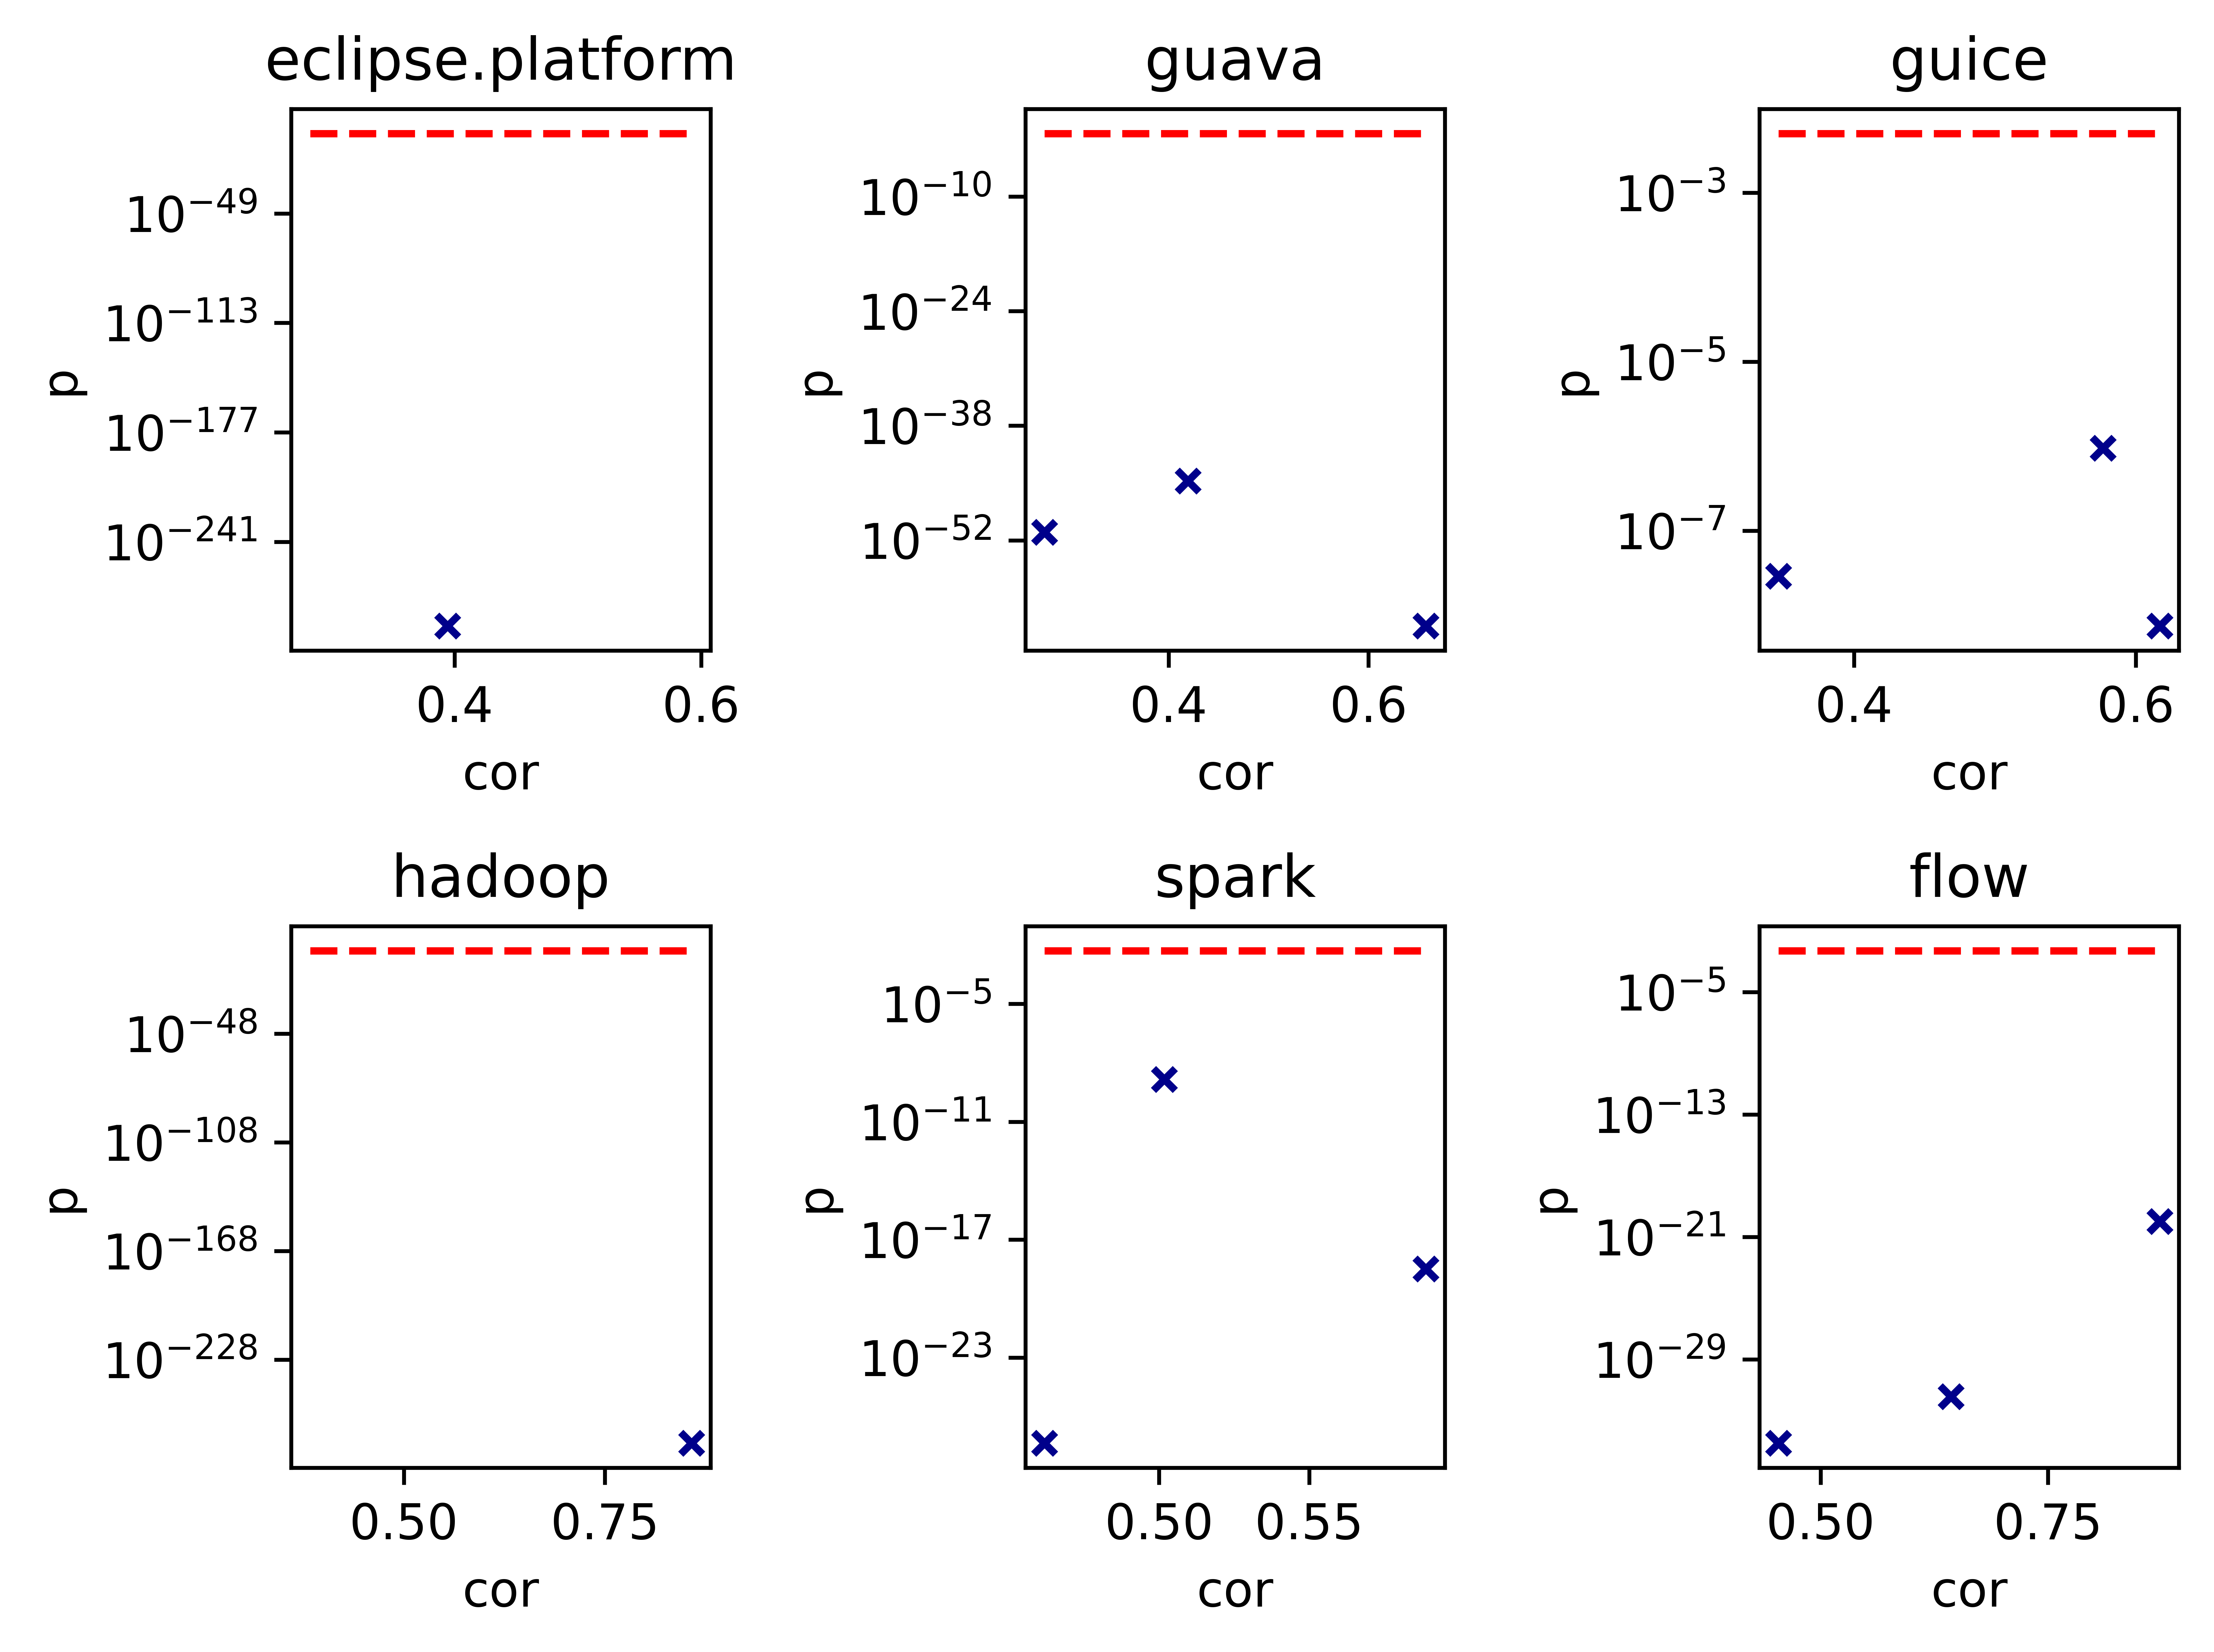

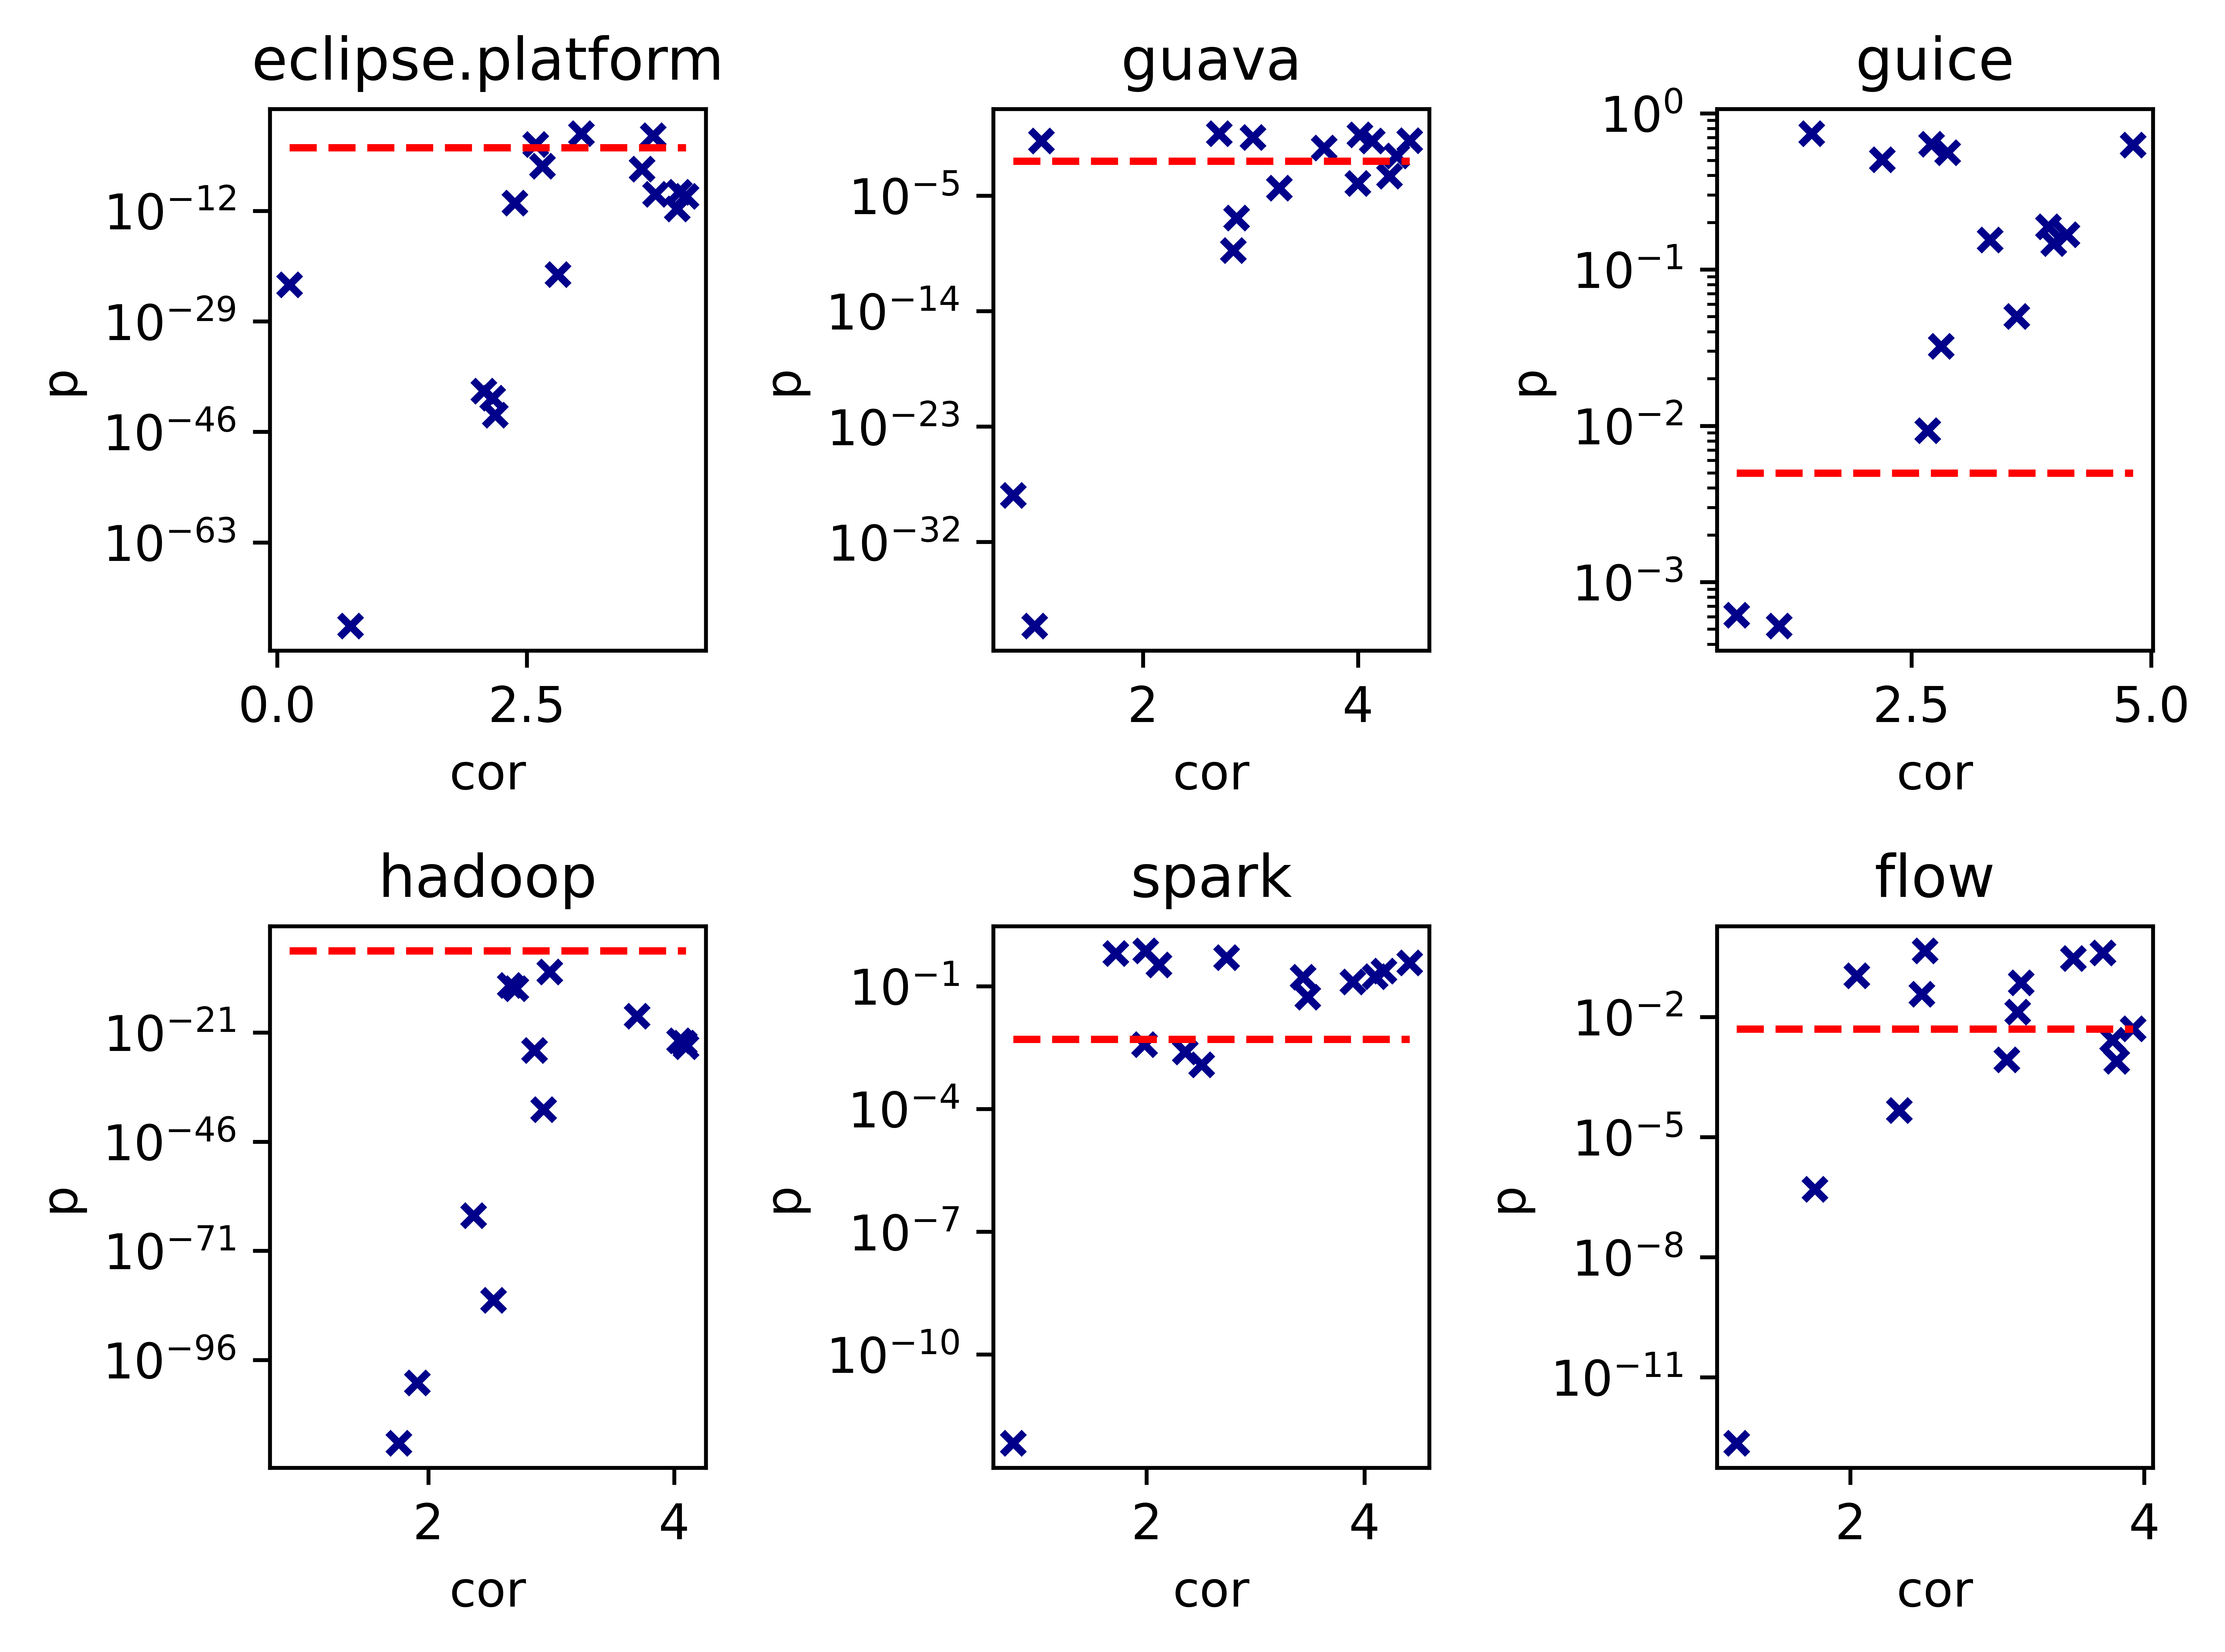

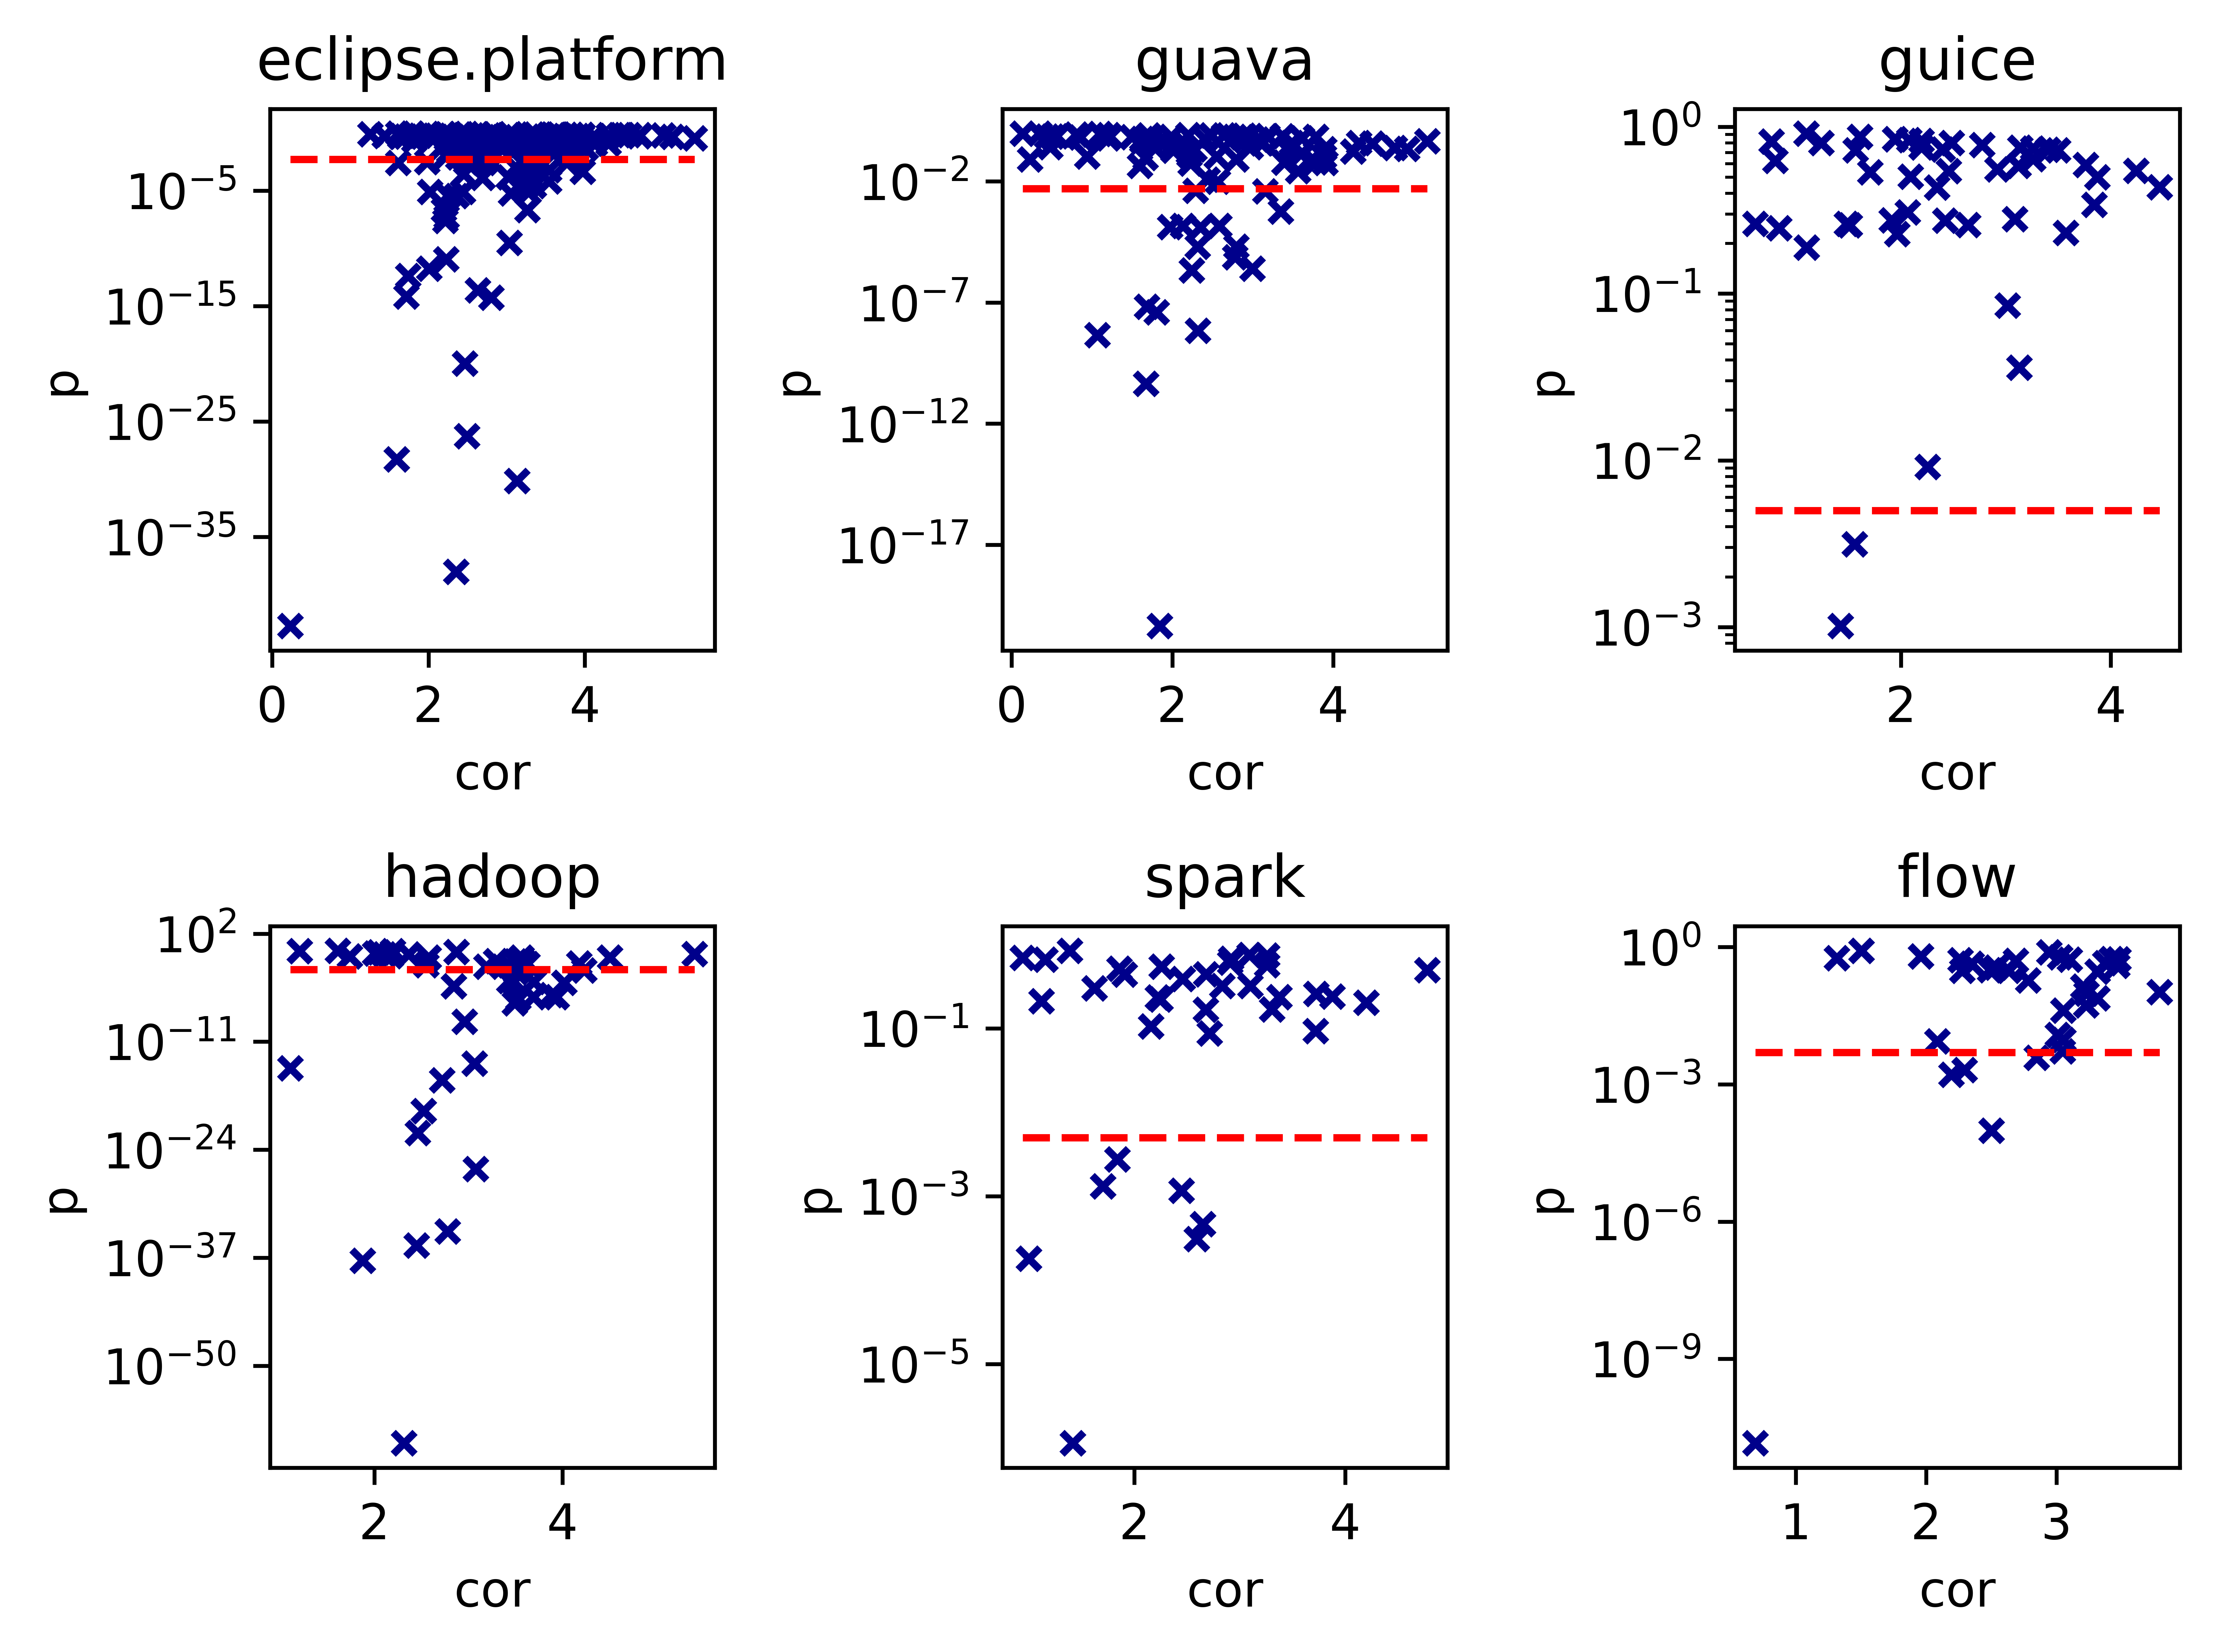

In [79]:
all_rules = ( (rules_pmd, "pmd"),
              (rules_sonar, "sonar"),
              (rules_sum, "sum"))

#recursions = {}

for comment_type in comments_types:
    if not comment_type in recursions:
        print("starting comment type", comment_type)
        recursions[comment_type] = {}
        recursions[comment_type][all_rules[2][1]] = plot_recursion(comment_type,all_rules[2][0],all_rules[2][1])
        save_analysis(comment_type.replace('/','='),all_rules[2][1], recursions[comment_type][all_rules[2][1]])   
        print("done all", comment_type)
        recursions[comment_type][all_rules[0][1]] = plot_recursion(comment_type,all_rules[0][0],all_rules[0][1])
        save_analysis(comment_type.replace('/','='), all_rules[0][1], recursions[comment_type][all_rules[0][1]])
        print("done pmd", comment_type)
        recursions[comment_type][all_rules[1][1]] = plot_recursion(comment_type,all_rules[1][0],all_rules[1][1])
        save_analysis(comment_type.replace('/','='), all_rules[1][1], recursions[comment_type][all_rules[1][1]])
        print("done sonar", comment_type)

In [104]:
#print(recursions['Number of commentsComment'])
def top_and_bot(comment_type, rule_type):
    top_result = {}
    bot_result = {}
    
    for project in all_projects:
        if not rule_type in recursions[comment_type]:
            return [], []
        df2 = recursions[comment_type][rule_type][project]
        df2 = df2[ df2['p'] < 0.005 ]
        df3 = df2.copy()
        df2 = df2[ df2['cor'].abs() > 0.15]
        top_result[project] = df2
        df3 = df3[ df3['cor'].abs() <= 0.15]
        bot_result[project] = df3


    d_rules = {}
    for project in all_projects:
        rules = top_result[project]
        for index, row in rules.iterrows():
            if index in d_rules:
                d_rules[index][0] += 1
                d_rules[index][1][project] = row['cor']
                
            else:
                d_rules[index] = [1, {project:row['cor']}]
            
    l_top = list(d_rules.items())
    l_top = sorted(l_top, key=lambda s: s[1][0], reverse=True)

    b_rules = {}
    for project in all_projects:
        rules = bot_result[project]
        for index, row in rules.iterrows():
            if index in b_rules:
                b_rules[index][0] += 1
                b_rules[index][1][project] = row['cor']
            else:
                b_rules[index] = [1, {project:row['cor']}]
    l_bot = list(b_rules.items())
    l_bot = sorted(l_bot, key=lambda s: s[1], reverse=True)
    return l_top, l_bot

    
print(recursions.keys())


dict_keys(['Number of commentsComment', 'Number of line comments', 'Number of Block comments', 'Number of Javadoc comments', 'Number of comments in methode', 'Number of method comments', 'Number of class comments', 'Number of line comments/loc', 'Number of Block comments/loc', 'Number of Javadoc comments/loc', 'Number of comments in methode/loc', 'Number of method comments/loc', 'Number of class comments/loc', 'Number of commentsComment/loc'])


In [105]:
#all_com_top, all_com_bot = top_and_bot("Number of commentsComment/loc",'sum')
sum = 0
for type in comments_types:
    print( type)
    for r in ('sonar', 'pmd', 'sum'):
        all_com_top, all_com_bot = top_and_bot(type,r)
        for val in all_com_top+all_com_bot:
            sum += val[1][0]
print( sum )


Number of commentsComment
Number of line comments
Number of Block comments
Number of Javadoc comments
Number of comments in methode
Number of method comments
Number of class comments
Number of commentsComment/loc
Number of line comments/loc
Number of Block comments/loc
Number of Javadoc comments/loc
Number of comments in methode/loc
Number of method comments/loc
Number of class comments/loc
1932


In [171]:
all_com_top, all_com_bot = top_and_bot("Number of commentsComment/loc",'sonar')
i = 0
for r in all_com_top:
    print( r[0], r[1] )
    i+=1
    if i > 3:
        break

i = 0
all_com_top, all_com_bot = top_and_bot("Number of Javadoc comments/loc",'sonar')
for r in all_com_top:
    print( r[0], r[1] )
    i+=1
    if i > 3:
        break

sonar_java:S3776 [4, {'eclipse.platform': 2.352125386040145, 'guava': 2.9939915848480587, 'hadoop': 2.7772371365056454, 'spark': 2.6492586109375105}]
sonar_java:S1874 [4, {'eclipse.platform': 2.2478055335214195, 'guava': 2.794511422375522, 'hadoop': 3.528931731013856, 'flow': 0.6885130747268671}]
sonar_java:S112 [4, {'guava': 1.96951535503359, 'hadoop': 2.4611307924691213, 'spark': 1.7009186102351779, 'flow': 2.847722567052731}]
sonar_java:S1192 [3, {'eclipse.platform': 3.132669396954551, 'hadoop': 2.4475279944011303, 'spark': 2.4453567193667367}]
sonar_java:S3776 [4, {'eclipse.platform': 2.352125386040145, 'guava': 2.9939915848480587, 'hadoop': 2.7772371365056454, 'spark': 2.6492586109375105}]
sonar_java:S1874 [4, {'eclipse.platform': 2.2478055335214195, 'guava': 2.794511422375522, 'hadoop': 3.528931731013856, 'flow': 0.6885130747268671}]
sonar_java:S112 [4, {'guava': 1.96951535503359, 'hadoop': 2.4611307924691213, 'spark': 1.7009186102351779, 'flow': 2.847722567052731}]
sonar_java:S1

In [21]:
comments_types = (#"loc",
                  "Number of commentsComment",
                  "Number of line comments",
                  "Number of Block comments",
                  "Number of Javadoc comments",
                  "Number of comments in methode",
                  "Number of method comments",
                  "Number of class comments")

[('pmd_MutableStaticState:', 1)]


In [77]:
recursions.pop('Number of commentsComment/loc', None)

{}